In [1]:
import rasterio as rio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import re
from tqdm import tqdm
import os
import cv2
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.interpolate import UnivariateSpline
from scipy.spatial import ConvexHull

In [2]:
%cd /scratch/user/anshulya
%ls

/scratch/user/anshulya
188.csv    241.csv    383/                             frequency.png
188_f.csv  270/       383.csv                          hls_data/
189/       270_f.csv  383_LAKE_MEAD.tif                hls_job1.sh
189.csv    271.csv    383_f.csv                        hls_job2.sh
189_f.csv  271_f.csv  383_in_situ.csv                  hls_job3.sh
193.csv    282.csv    384/                             hls_job4.sh
193_f.csv  282_f.csv  384.csv                          jrc_data/
196.csv    308/       384_f.csv                        jupyter_notebooks/
196_f.csv  308.csv    DAACDataDownload.py              lake_rf_new.pkl
200.csv    308_f.csv  LAKE_MEAD_dem.tif                lake_rf_new_L30.pkl
200_f.csv  320.csv    PIP_CACHE/                       log_files/
206.csv    320_f.csv  Untitled.ipynb                   max_img_extent.csv
206_f.csv  339.csv    WT_432.geojson                   ondemand/
213.csv    339_f.csv  area_job1.sh                     ondemand-faster/
213_f.csv  34

In [3]:
def preprocess_reservoir_shp(fname):
    reservoirs = gp.read_file(fname)

    reservoirs.loc[31,'new_name'] = 'FARMER_S CREEK RESERVOIR'
    reservoirs.loc[106,'new_name'] = 'LAKE O THE PINES'

    t = ['/' in s for s in reservoirs['new_name']]
    i = 0
    res_names = ['COX LAKE','EAGLE NEST LAKE_MANOR LAKE','LAKE BALLINGER_LAKE MOONEN','LAKE OLNEY_LAKE COOPER','LAKE WINTERS_NEW LAKE WINTERS','MUSTANG LAKE']
    for res_idx in [23, 28, 56, 107, 129, 141]:
        reservoirs.loc[res_idx, 'new_name'] = res_names[i]
        i = i + 1

    i = 0
    res_names = ['LAKE GONZALES','CLEAR LAKE WA','CLEAR LAKE OR']
    for res_idx in [84, 388, 389]:
        reservoirs.loc[res_idx, 'new_name'] = res_names[i]
        i = i + 1

    for i in range(432):
        string = reservoirs.loc[i, 'new_name']
        regex = re.compile('[@!#$%^&*()<>?/\|}{~]')
        # Pass the string in search
        # method of regex object.
        if(regex.search(string) == None):
            continue
        else:
            print(i,string)

    return reservoirs

In [4]:
fname = 'WT_432.geojson'
reservoirs = preprocess_reservoir_shp(fname)
for idx, row in reservoirs.iterrows():
    lat = row['geometry'].centroid.y
    area = row['geometry'].area*111*111*np.cos(lat/180*np.pi)
    reservoirs.loc[idx,'area'] = area

In [5]:
res_idx = 308
im_name = str(reservoirs.loc[res_idx,'FID']) + '_' + reservoirs.loc[res_idx,'new_name'].replace(" ", "_")
gdf = reservoirs.loc[[res_idx]]
gdf['geometry'] = gdf['geometry'].buffer(0.005)

/tmp/job.452098/ipykernel_3002993/460584472.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(0.005)


<Axes: >

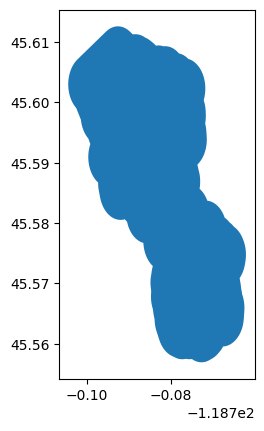

In [6]:
gdf.plot()

In [9]:
dir_path = os.path.join('opera_data', str(res_idx) + '_merged')

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory {dir_path} created.")
else:
    print(f"Directory {dir_path} already exists.")

dir_path = os.path.join('opera_data', str(res_idx) + '_re')

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory {dir_path} created.")
else:
    print(f"Directory {dir_path} already exists.")

Directory opera_data/383_merged already exists.
Directory opera_data/383_re already exists.


In [10]:
# Specify the directory path
dirpath = 'opera_data/'+str(res_idx)

# List all files in the directory
all_files = os.listdir(dirpath)

# Filter files that contain the string 'B07_LAND'
filtered_files = [f for f in all_files if 'BWTR' in f]

In [11]:
date = []
for f in filtered_files:
    date.append(datetime(int(f.split('_')[4][:4]),
         int(f.split('_')[4][4:6]),
         int(f.split('_')[4][6:8])))
opera_df = pd.DataFrame({'datetime':date,'filename':filtered_files})
opera_df = opera_df.sort_values(by='datetime')
opera_df

datetime                                           filename
29  2023-04-09  OPERA_L3_DSWx-HLS_T12STF_20230409T181446Z_2023...
104 2023-04-09  OPERA_L3_DSWx-HLS_T11SQV_20230409T181509Z_2023...
58  2023-04-09  OPERA_L3_DSWx-HLS_T11SPV_20230409T181509Z_2023...
212 2023-04-09  OPERA_L3_DSWx-HLS_T12STE_20230409T181509Z_2023...
371 2023-04-09  OPERA_L3_DSWx-HLS_T11SQA_20230409T181446Z_2023...
..         ...                                                ...
295 2023-09-25  OPERA_L3_DSWx-HLS_T11SPA_20230925T183029Z_2023...
127 2023-09-25  OPERA_L3_DSWx-HLS_T11SQA_20230925T180905Z_2023...
462 2023-09-25  OPERA_L3_DSWx-HLS_T11SPV_20230925T183029Z_2023...
141 2023-09-25  OPERA_L3_DSWx-HLS_T12STF_20230925T180905Z_2023...
504 2023-09-25  OPERA_L3_DSWx-HLS_T11SQV_20230925T180929Z_2023...

[525 rows x 2 columns]

In [19]:
def reproject_raster_to_4326(src_path, dst_path):
    dst_crs = 'EPSG:4326'
    
    with rio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [20]:
def merge_rasters_by_datetime(df):
    # Group by datetime
    grouped = df.groupby('datetime')

    for datetime, group in grouped:
        reprojected_rasters = []
        
        # Reproject each raster in the group
        for filename in group['filename']:
            reprojected_path = f"opera_data/{str(res_idx)}_re/reprojected_{filename}"
            reproject_raster_to_4326(os.path.join('opera_data', str(res_idx),filename), reprojected_path)
            reprojected_rasters.append(reprojected_path)
        
        merged_raster_path = f"opera_data/{str(res_idx)}_merged/merged_{datetime}.tif"
        
        # Merge reprojected rasters
        src_files_to_mosaic = [rio.open(path) for path in reprojected_rasters]
        mosaic, out_trans = merge(src_files_to_mosaic)

        out_meta = src_files_to_mosaic[0].meta.copy()
        out_meta.update({
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans
        })

        with rio.open(merged_raster_path, "w", **out_meta) as dest:
            dest.write(mosaic)

        # Close the rasterio datasets and optionally remove reprojected rasters
        for src in src_files_to_mosaic:
            src.close()

In [21]:
merge_rasters_by_datetime(opera_df)

NameError: name 'calculate_default_transform' is not defined

## Lake Mead

In [22]:
# Specify the directory path
dirpath = 'opera_data/'+str(res_idx)+'_merged'

# List all files in the directory
all_files = os.listdir(dirpath)

  0%|          | 0/112 [00:00<?, ?it/s]

3.4024252341338026


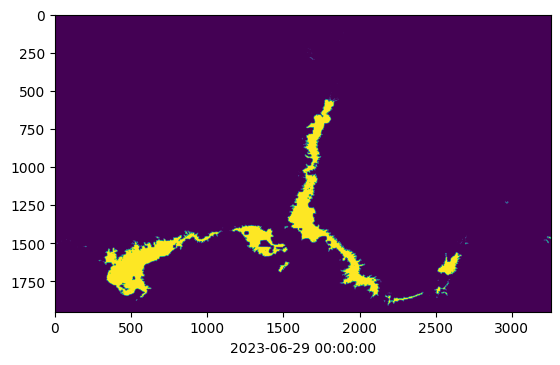

  1%|          | 1/112 [00:02<05:14,  2.83s/it]

10.791480490445185


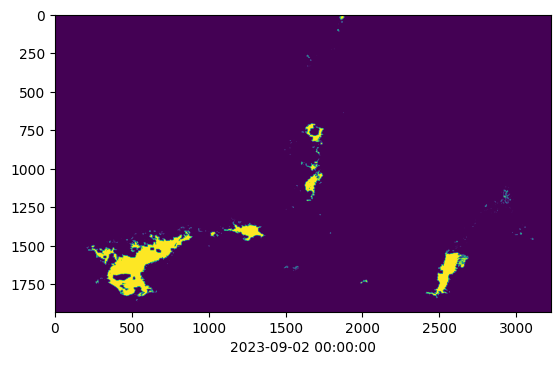

  2%|▏         | 2/112 [00:05<04:51,  2.65s/it]

0.0


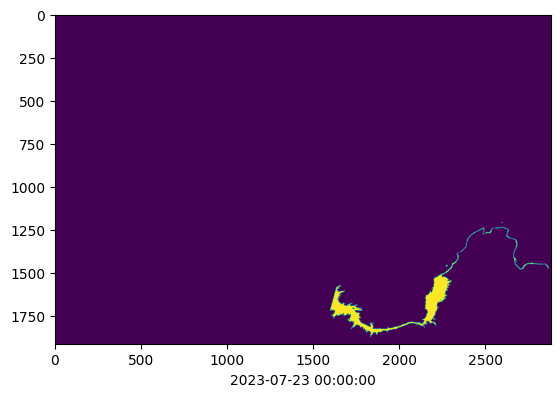

  3%|▎         | 3/112 [00:06<03:43,  2.05s/it]

0.0


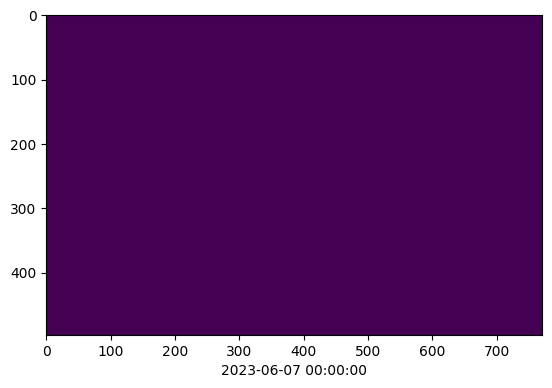

  4%|▎         | 4/112 [00:07<02:43,  1.52s/it]

0.0


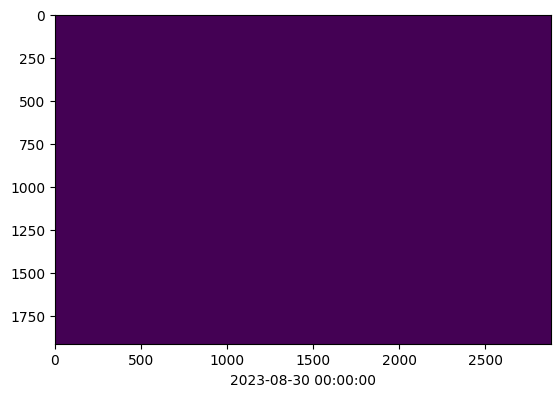

  4%|▍         | 5/112 [00:08<02:20,  1.31s/it]

1.0646146400514869


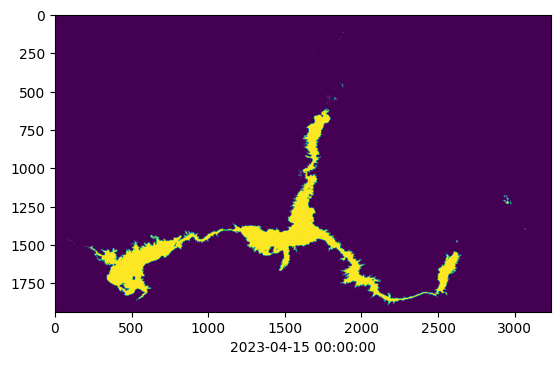

  5%|▌         | 6/112 [00:10<02:55,  1.65s/it]

0.014723003550746041


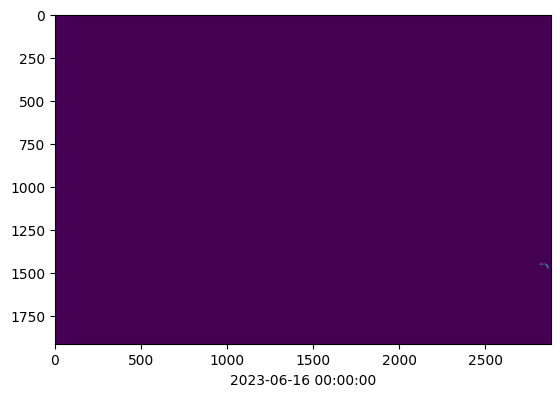

  6%|▋         | 7/112 [00:12<02:53,  1.66s/it]

0.0


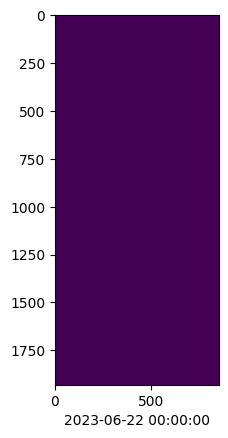

  7%|▋         | 8/112 [00:13<02:33,  1.48s/it]

1.2274091288553959


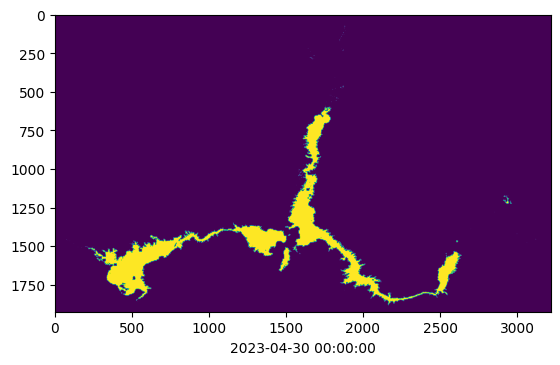

  8%|▊         | 9/112 [00:15<03:06,  1.81s/it]

0.6547401911194515


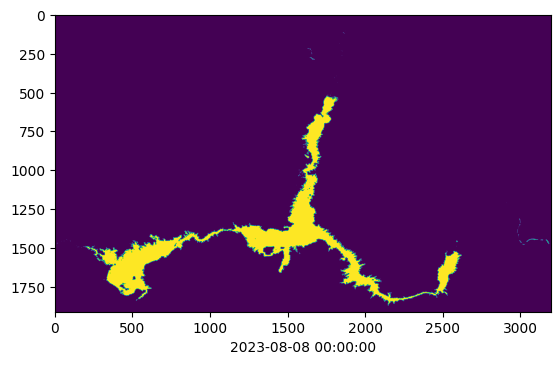

  9%|▉         | 10/112 [00:18<03:25,  2.01s/it]

0.06099959281077803


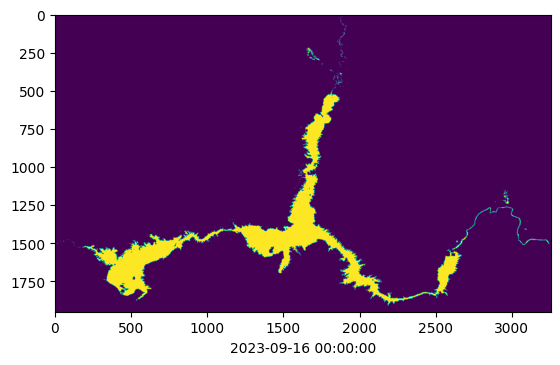

 10%|▉         | 11/112 [00:21<04:06,  2.44s/it]

0.04029658284977434


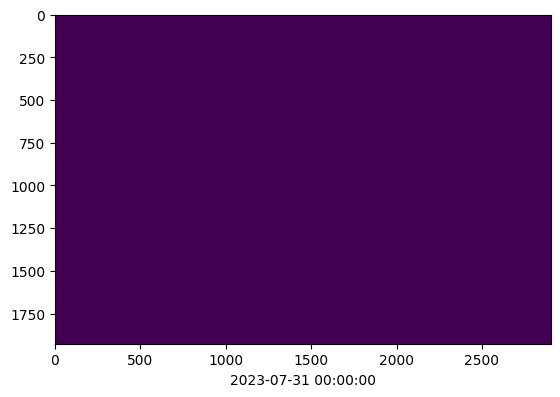

 11%|█         | 12/112 [00:23<03:25,  2.06s/it]

2.9288552628971205


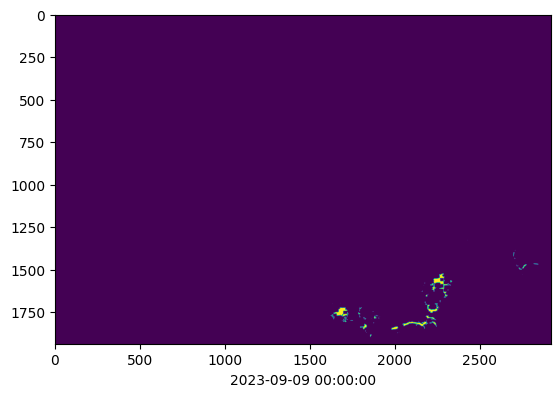

 12%|█▏        | 13/112 [00:24<03:13,  1.96s/it]

0.0


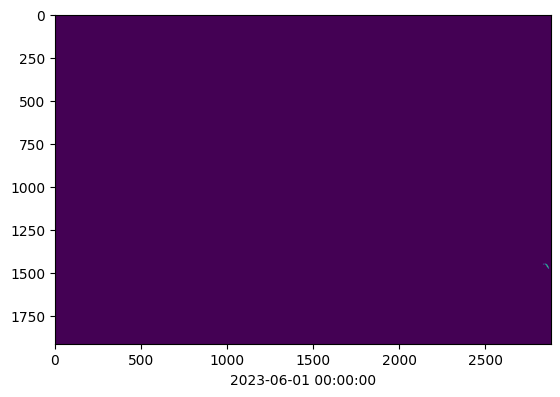

 12%|█▎        | 14/112 [00:25<02:42,  1.66s/it]

11.069927805404442


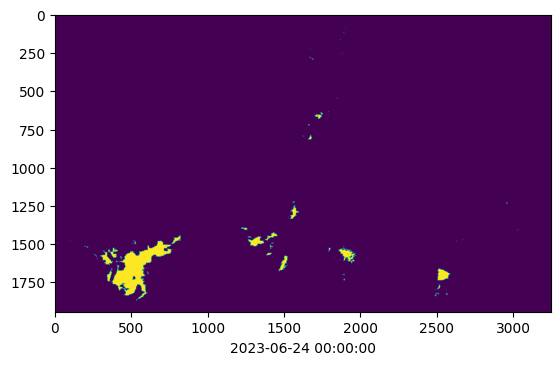

 13%|█▎        | 15/112 [00:28<03:09,  1.96s/it]

0.0


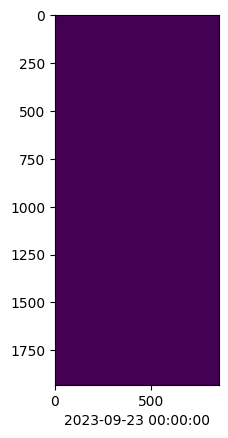

 14%|█▍        | 16/112 [00:29<02:35,  1.62s/it]

1.2305970553789949


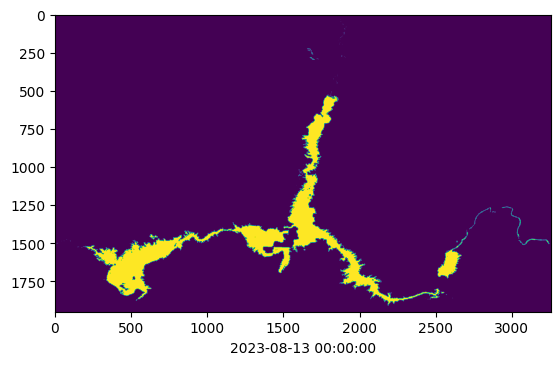

 15%|█▌        | 17/112 [00:31<02:39,  1.68s/it]

0.0


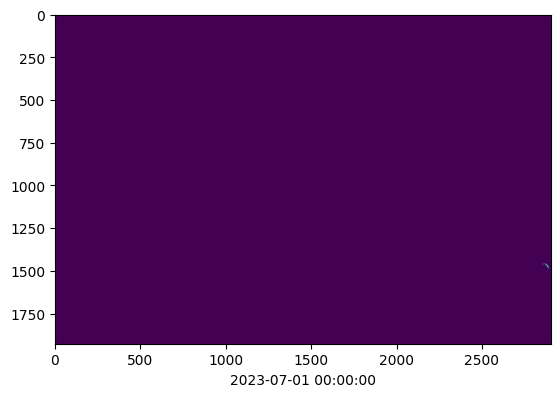

 16%|█▌        | 18/112 [00:32<02:42,  1.73s/it]

0.176812505131668


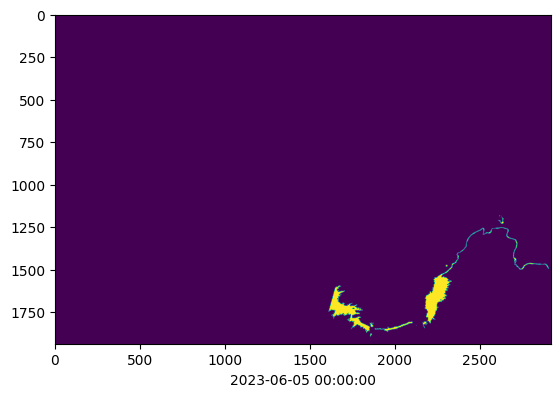

 17%|█▋        | 19/112 [00:34<02:26,  1.57s/it]

0.0


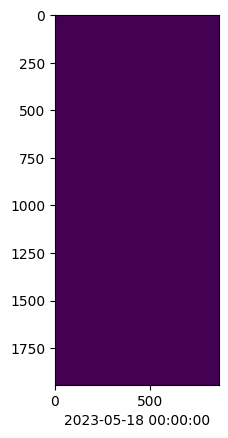

 18%|█▊        | 20/112 [00:34<02:04,  1.35s/it]

3.2912291499103725


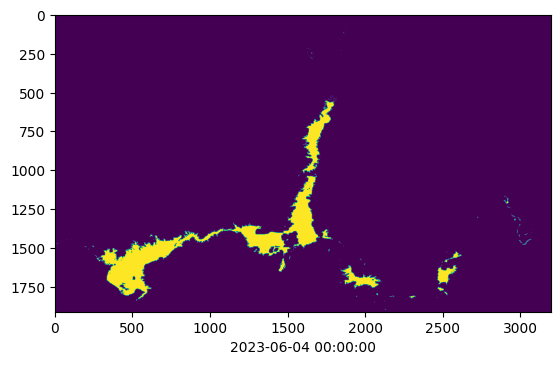

 19%|█▉        | 21/112 [00:37<02:26,  1.61s/it]

10.154694490277002


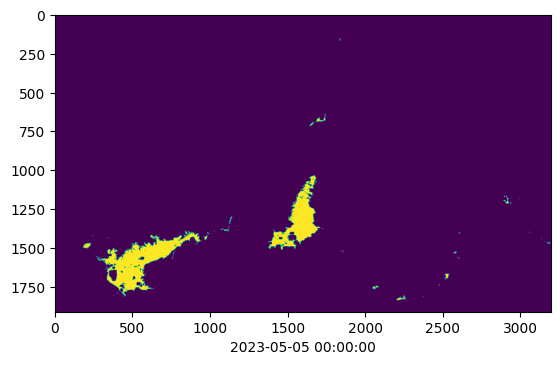

 20%|█▉        | 22/112 [00:39<02:47,  1.86s/it]

1.4327014080537703


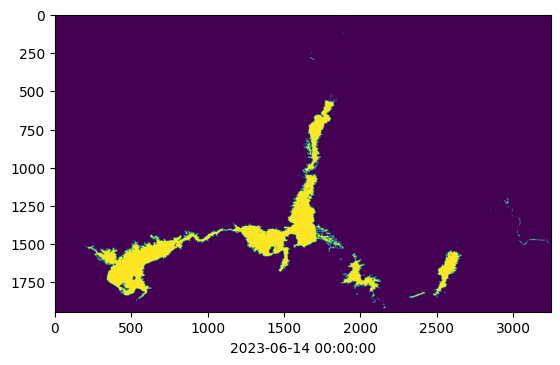

 21%|██        | 23/112 [00:41<02:58,  2.01s/it]

2.183212085854174


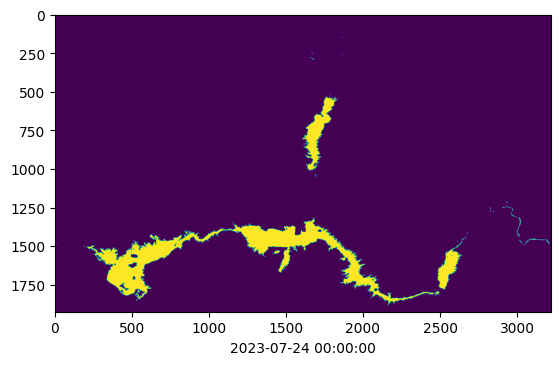

 21%|██▏       | 24/112 [00:44<03:20,  2.28s/it]

0.0


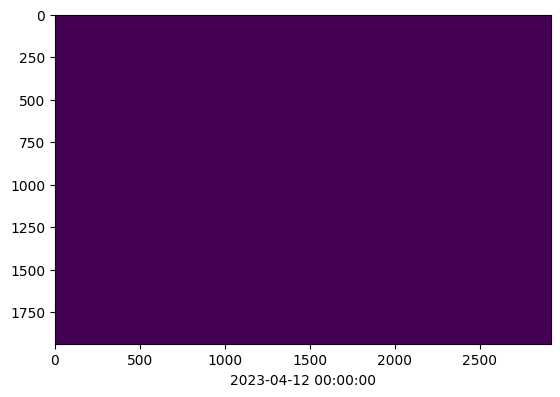

 22%|██▏       | 25/112 [00:46<02:59,  2.06s/it]

0.0


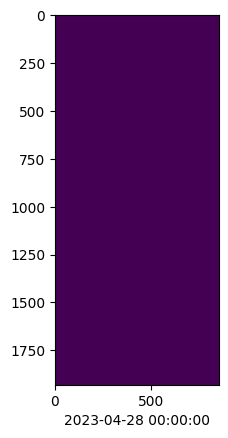

 23%|██▎       | 26/112 [00:47<02:32,  1.77s/it]

0.0


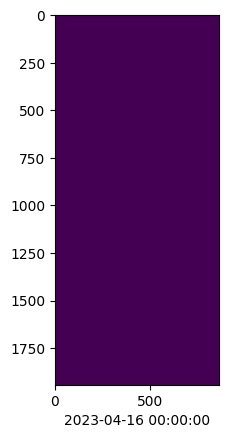

 24%|██▍       | 27/112 [00:48<02:09,  1.53s/it]

0.6571928302490851


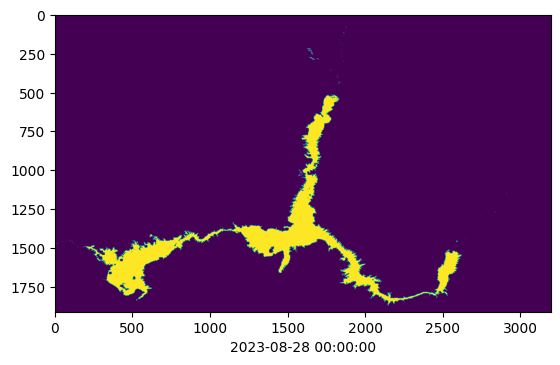

 25%|██▌       | 28/112 [00:50<02:33,  1.83s/it]

0.0


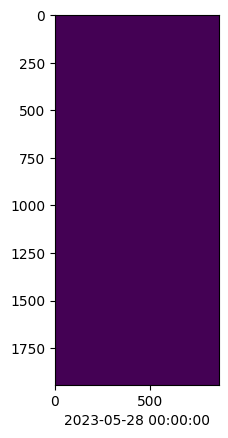

 26%|██▌       | 29/112 [00:52<02:15,  1.63s/it]

0.0


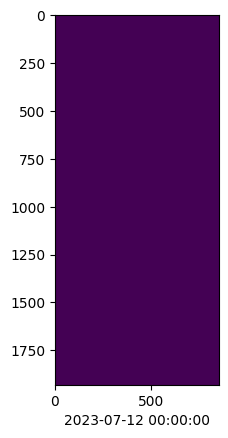

 27%|██▋       | 30/112 [00:53<02:01,  1.48s/it]

0.05142951904286055


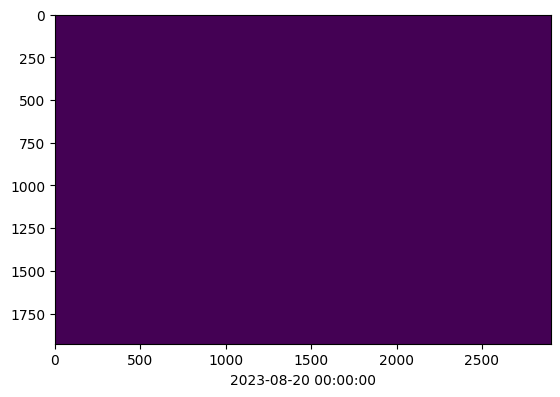

 28%|██▊       | 31/112 [00:54<01:59,  1.47s/it]

1.546556059269089


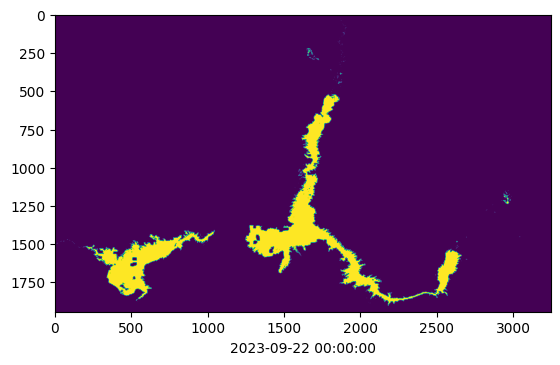

 29%|██▊       | 32/112 [00:57<02:29,  1.87s/it]

4.032900147105395


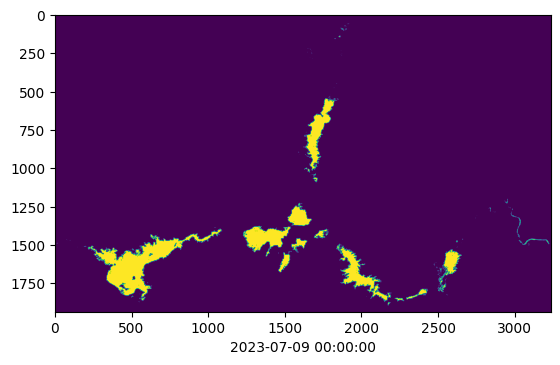

 29%|██▉       | 33/112 [00:59<02:42,  2.05s/it]

0.0


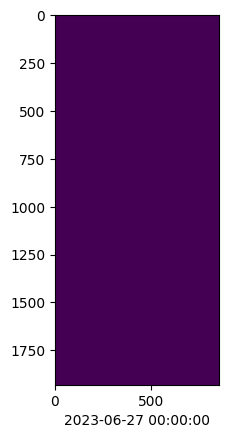

 30%|███       | 34/112 [01:01<02:20,  1.80s/it]

8.195486177142728


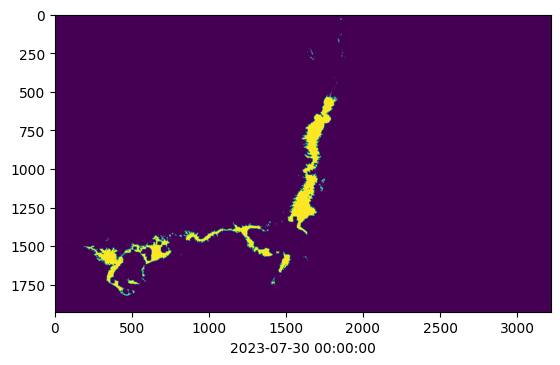

 31%|███▏      | 35/112 [01:04<02:48,  2.19s/it]

0.0


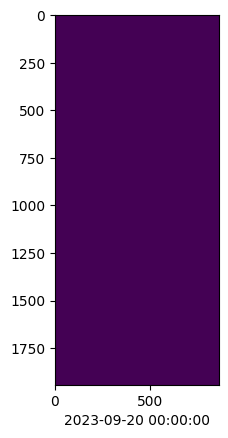

 32%|███▏      | 36/112 [01:05<02:20,  1.85s/it]

0.0


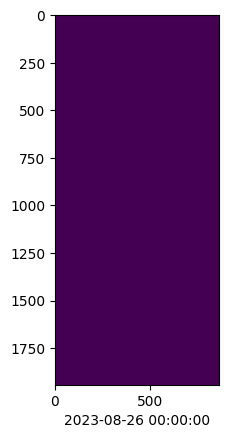

 33%|███▎      | 37/112 [01:06<01:52,  1.50s/it]

0.264051128696352


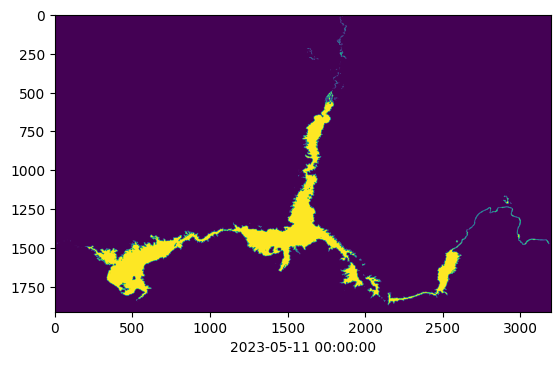

 34%|███▍      | 38/112 [01:08<02:22,  1.93s/it]

0.0


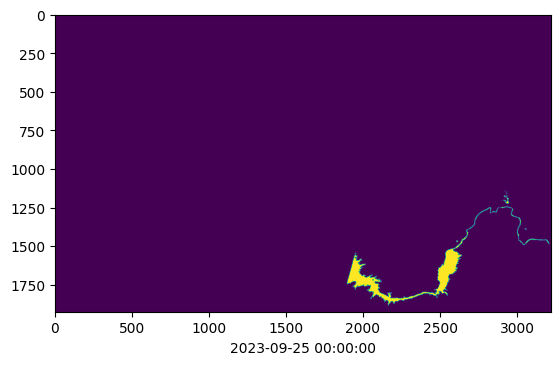

 35%|███▍      | 39/112 [01:10<02:20,  1.92s/it]

0.0


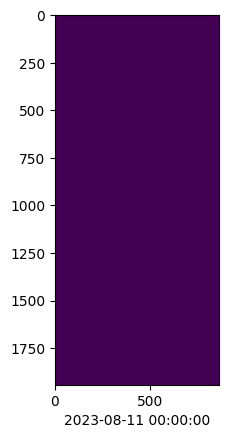

 36%|███▌      | 40/112 [01:11<01:55,  1.61s/it]

0.0


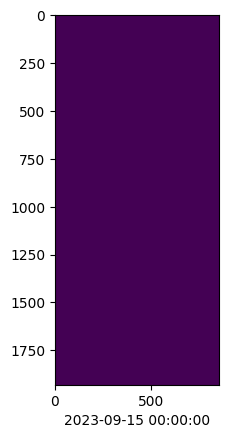

 37%|███▋      | 41/112 [01:12<01:37,  1.37s/it]

0.0


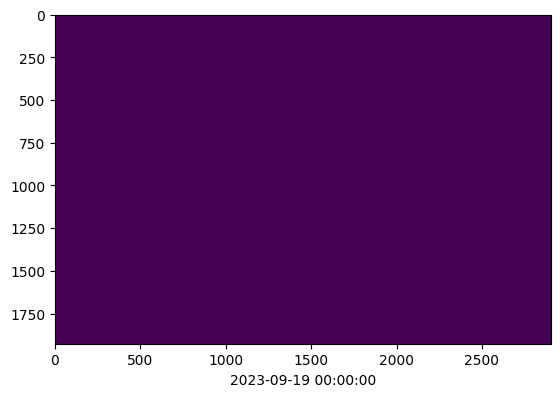

 38%|███▊      | 42/112 [01:13<01:30,  1.29s/it]

0.873234935574597


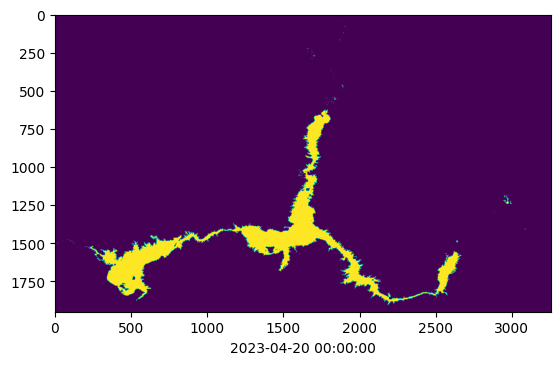

 38%|███▊      | 43/112 [01:16<01:51,  1.62s/it]

0.0


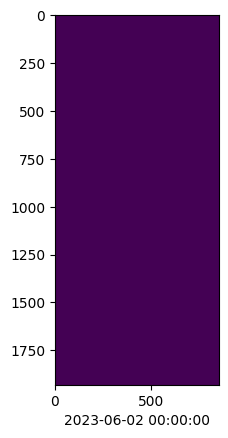

 39%|███▉      | 44/112 [01:17<01:43,  1.52s/it]

0.0


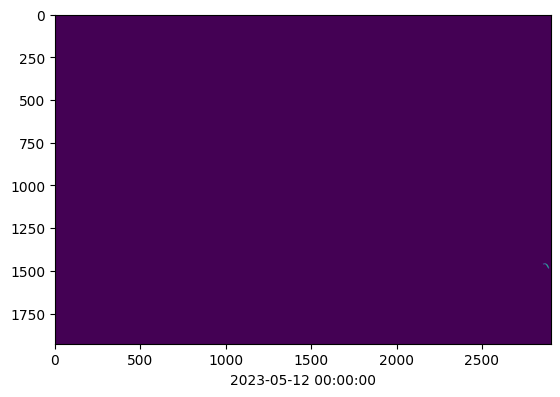

 40%|████      | 45/112 [01:18<01:35,  1.43s/it]

0.4561794322674194


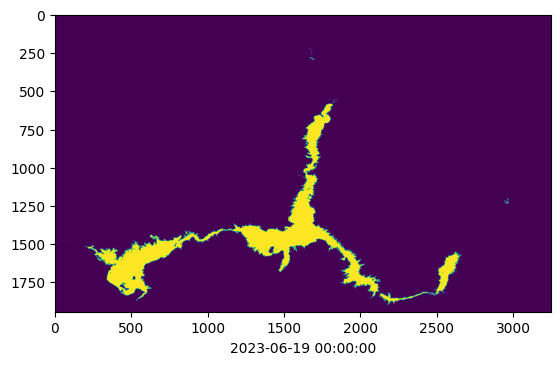

 41%|████      | 46/112 [01:21<01:57,  1.78s/it]

0.0


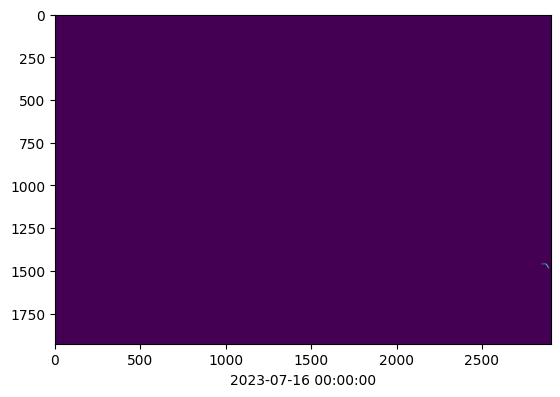

 42%|████▏     | 47/112 [01:22<01:43,  1.60s/it]

0.056879386870308295


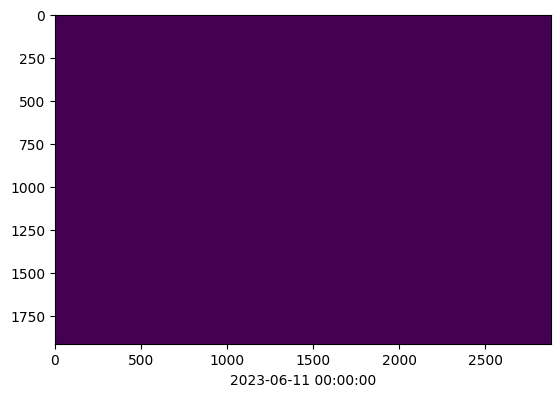

 43%|████▎     | 48/112 [01:23<01:42,  1.60s/it]

0.0


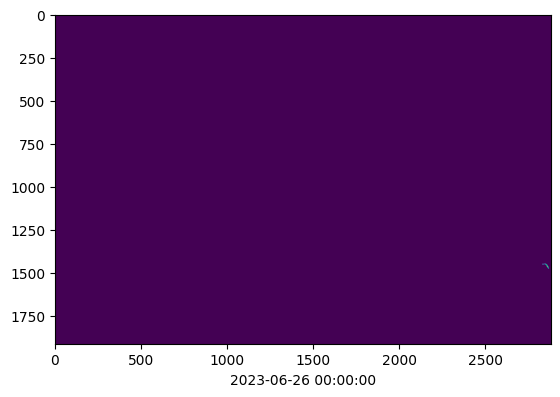

 44%|████▍     | 49/112 [01:25<01:31,  1.45s/it]

0.9404890006492953


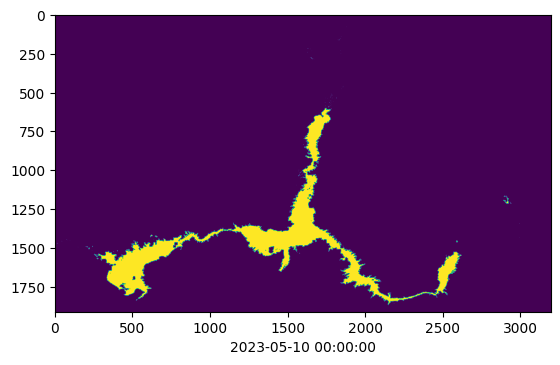

 45%|████▍     | 50/112 [01:27<01:53,  1.83s/it]

1.4912372926722828


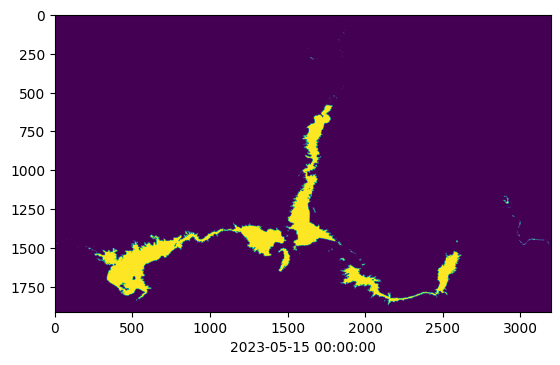

 46%|████▌     | 51/112 [01:30<02:03,  2.03s/it]

0.0


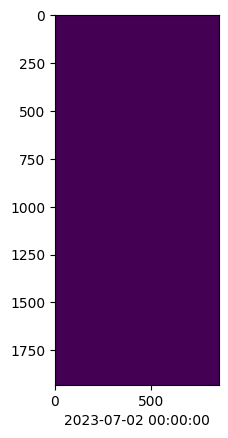

 46%|████▋     | 52/112 [01:31<01:43,  1.73s/it]

0.0


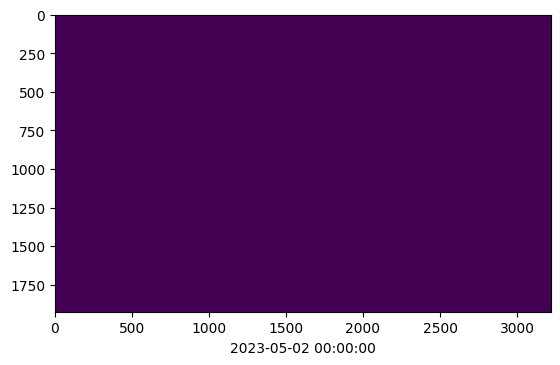

 47%|████▋     | 53/112 [01:32<01:40,  1.71s/it]

2.165598596828803


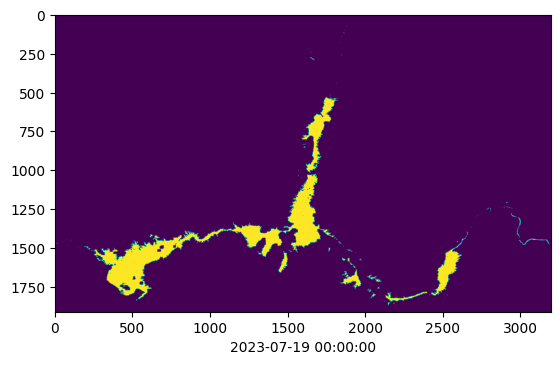

 48%|████▊     | 54/112 [01:35<01:50,  1.90s/it]

1.1639299359478594


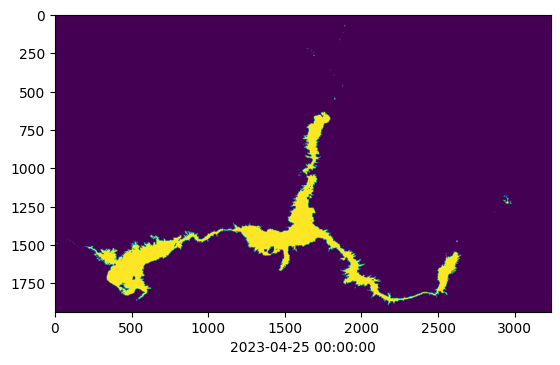

 49%|████▉     | 55/112 [01:37<02:00,  2.11s/it]

2.892030747283513


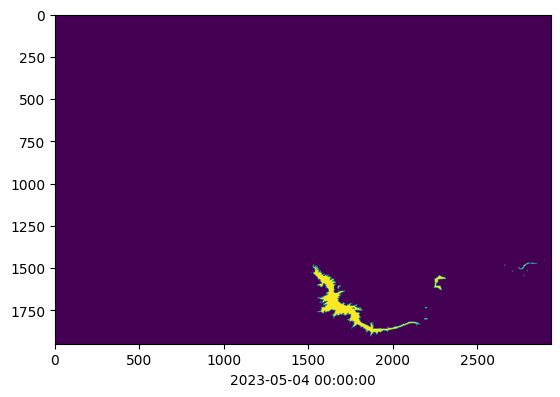

 50%|█████     | 56/112 [01:38<01:39,  1.78s/it]

0.0


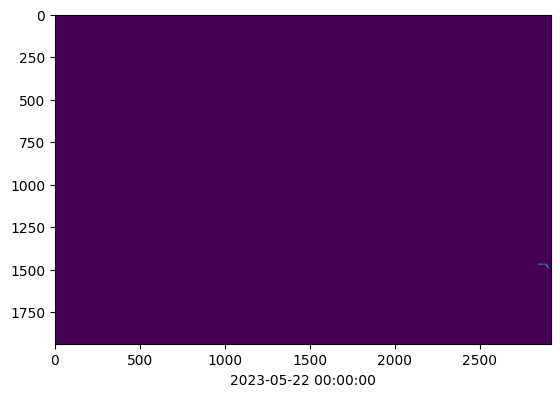

 51%|█████     | 57/112 [01:40<01:27,  1.60s/it]

2.3494320750586057


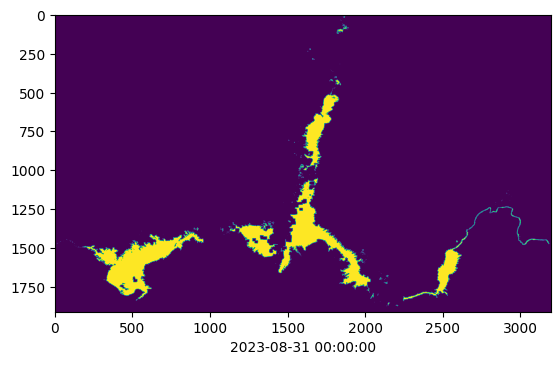

 52%|█████▏    | 58/112 [01:42<01:45,  1.96s/it]

2.2123195924306716


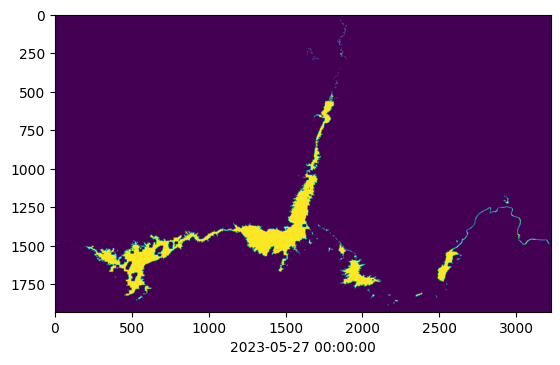

 53%|█████▎    | 59/112 [01:45<01:51,  2.11s/it]

1.6484860250894116


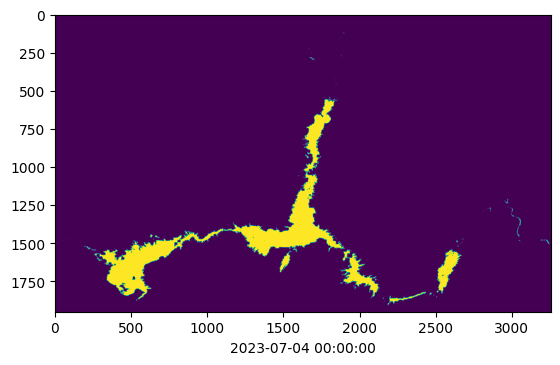

 54%|█████▎    | 60/112 [01:48<02:02,  2.35s/it]

0.0


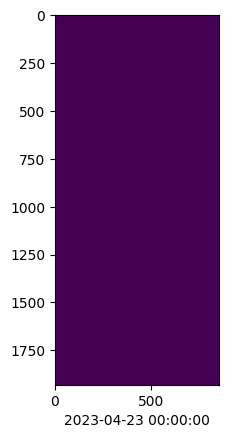

 54%|█████▍    | 61/112 [01:48<01:34,  1.85s/it]

0.0


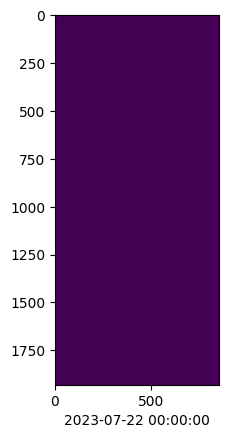

 55%|█████▌    | 62/112 [01:50<01:21,  1.64s/it]

0.8015296662546353


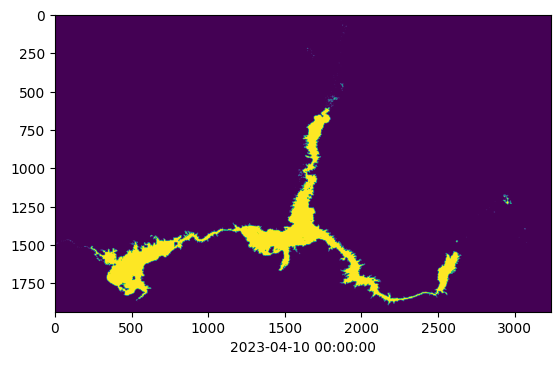

 56%|█████▋    | 63/112 [01:52<01:32,  1.88s/it]

0.0


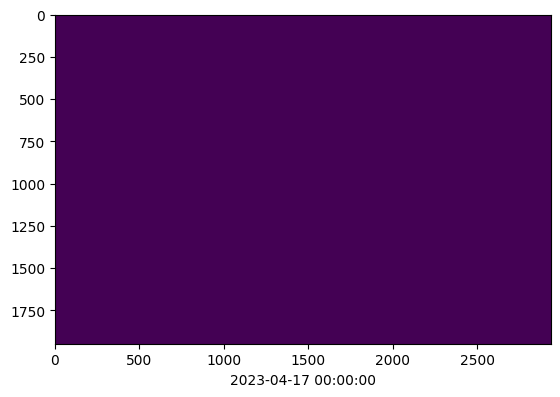

 57%|█████▋    | 64/112 [01:53<01:18,  1.64s/it]

3.403914904665832


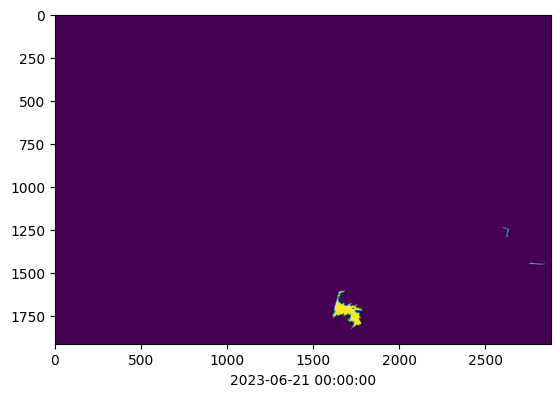

 58%|█████▊    | 65/112 [01:55<01:21,  1.73s/it]

0.00463619659172308


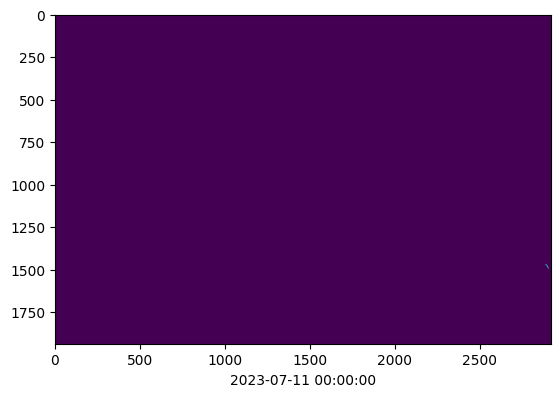

 59%|█████▉    | 66/112 [01:56<01:12,  1.58s/it]

0.0


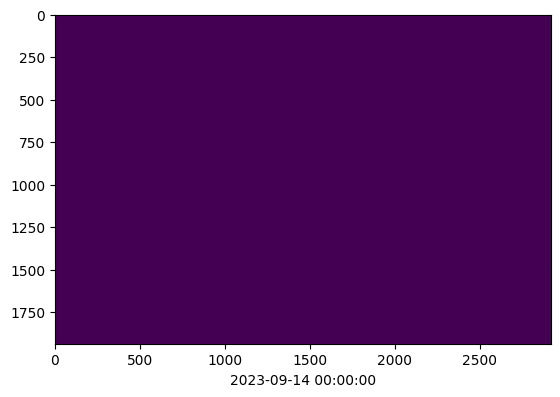

 60%|█████▉    | 67/112 [01:57<01:03,  1.41s/it]

2.5251438281578755


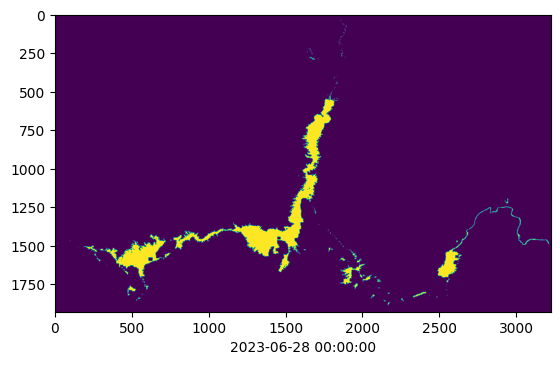

 61%|██████    | 68/112 [01:59<01:11,  1.63s/it]

0.0


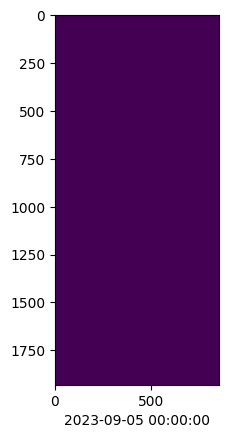

 62%|██████▏   | 69/112 [02:00<00:57,  1.34s/it]

0.0


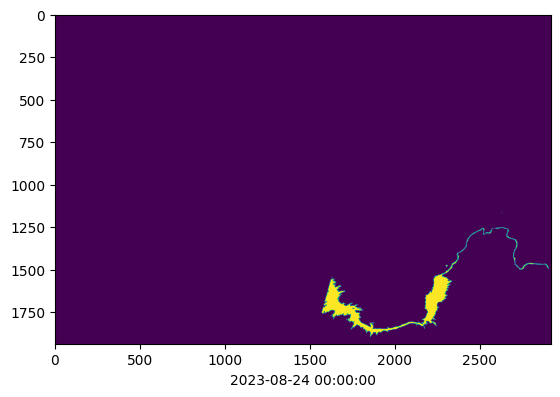

 62%|██████▎   | 70/112 [02:01<00:55,  1.31s/it]

0.0


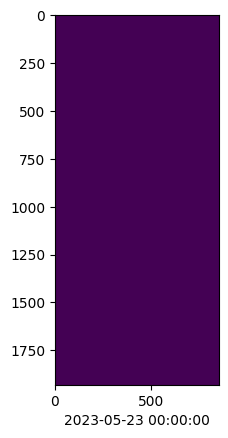

 63%|██████▎   | 71/112 [02:02<00:47,  1.16s/it]

0.5774431340190236


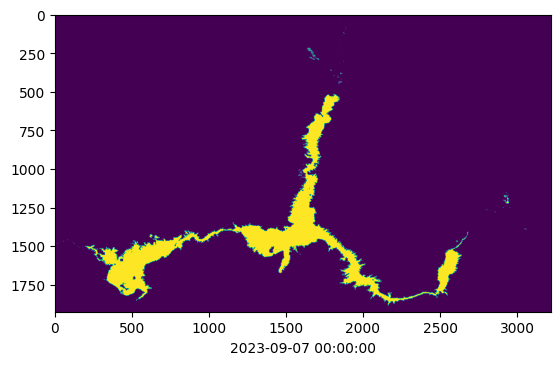

 64%|██████▍   | 72/112 [02:04<00:56,  1.41s/it]

5.399371354289042


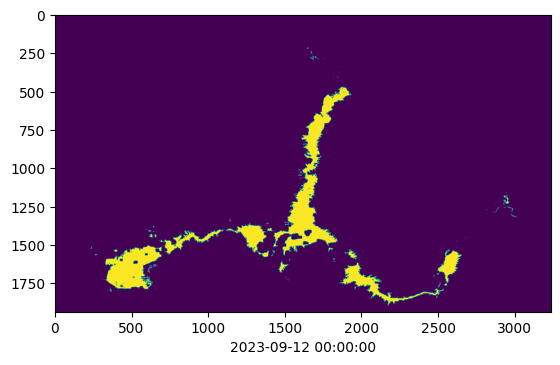

 65%|██████▌   | 73/112 [02:07<01:10,  1.80s/it]

0.0


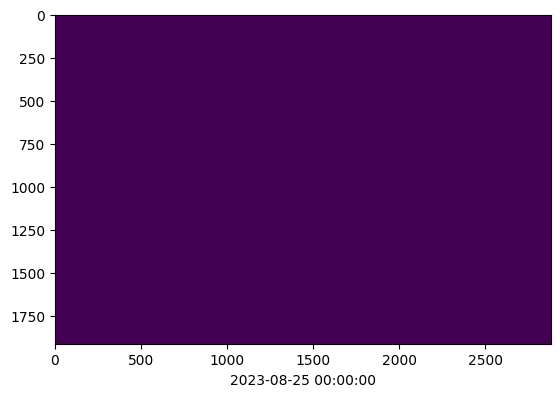

 66%|██████▌   | 74/112 [02:08<00:58,  1.54s/it]

0.0


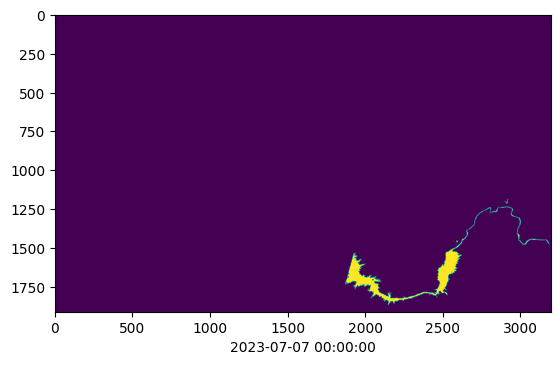

 67%|██████▋   | 75/112 [02:10<01:02,  1.70s/it]

2.951761016222558


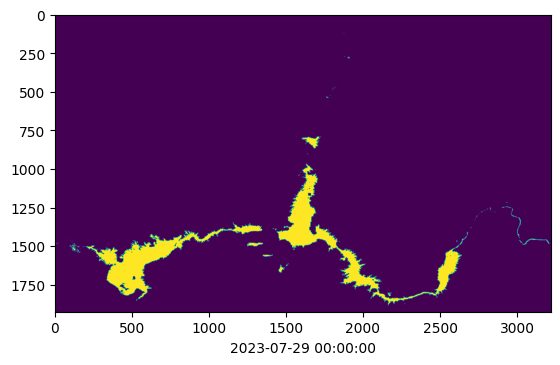

 68%|██████▊   | 76/112 [02:12<01:06,  1.85s/it]

14.732516567140685


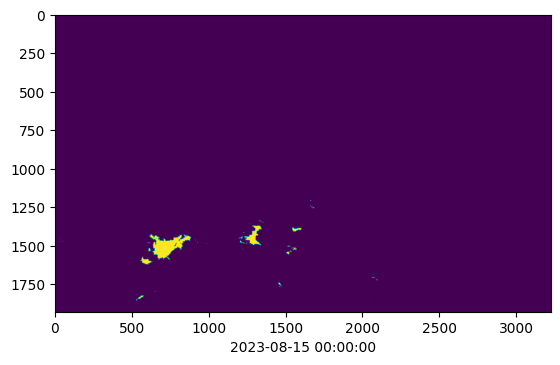

 69%|██████▉   | 77/112 [02:15<01:16,  2.19s/it]

0.07369363038172386


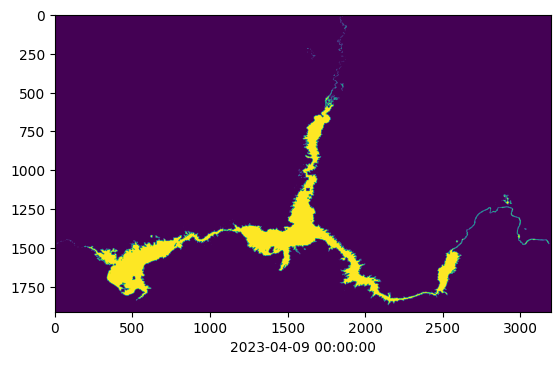

 70%|██████▉   | 78/112 [02:18<01:18,  2.30s/it]

0.0


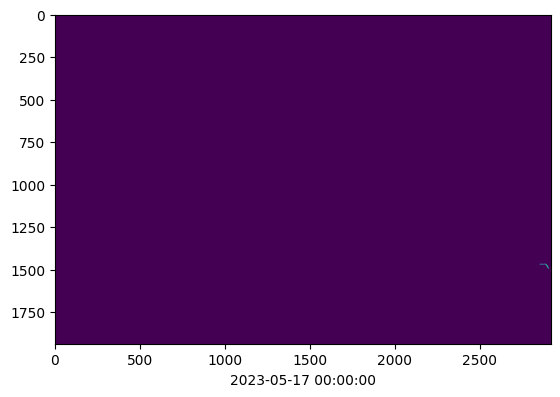

 71%|███████   | 79/112 [02:19<01:04,  1.95s/it]

1.0940325266373137


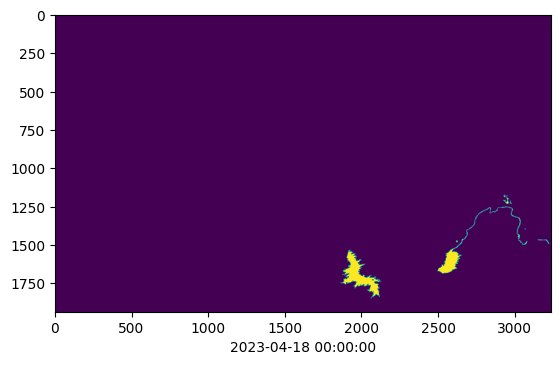

 71%|███████▏  | 80/112 [02:22<01:12,  2.27s/it]

0.0


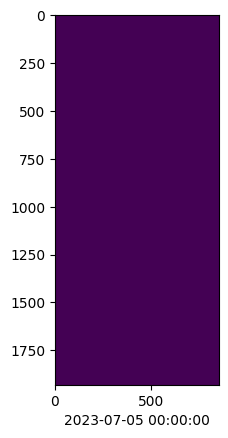

 72%|███████▏  | 81/112 [02:23<00:56,  1.83s/it]

0.0


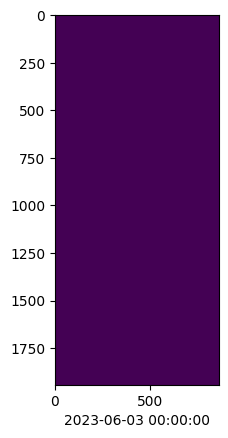

 73%|███████▎  | 82/112 [02:23<00:44,  1.47s/it]

0.0


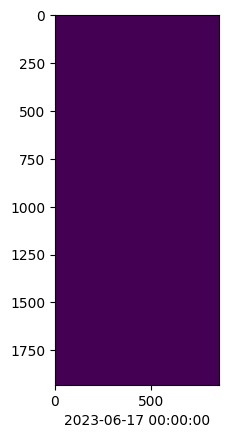

 74%|███████▍  | 83/112 [02:24<00:35,  1.23s/it]

0.0


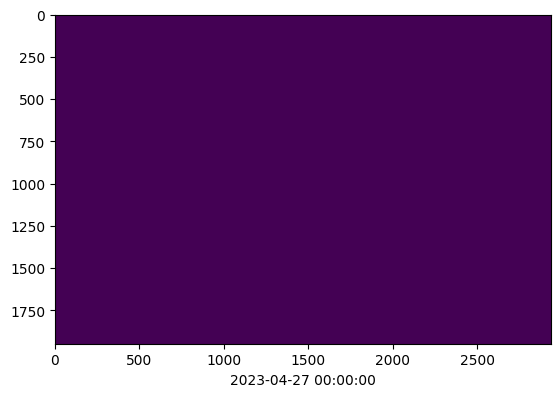

 75%|███████▌  | 84/112 [02:25<00:33,  1.20s/it]

0.0


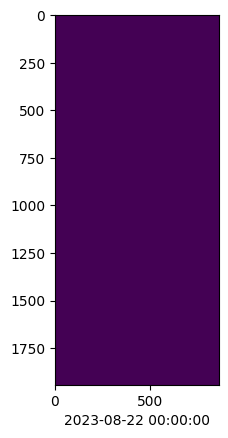

 76%|███████▌  | 85/112 [02:26<00:28,  1.04s/it]

1.2000760684229017


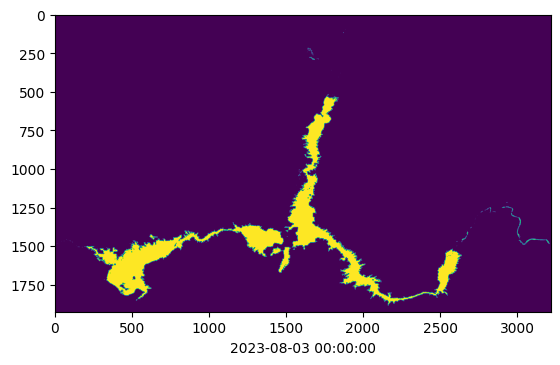

 77%|███████▋  | 86/112 [02:28<00:36,  1.39s/it]

0.0


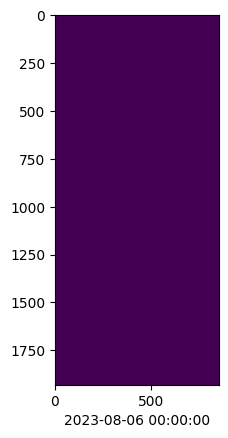

 78%|███████▊  | 87/112 [02:29<00:31,  1.27s/it]

0.0


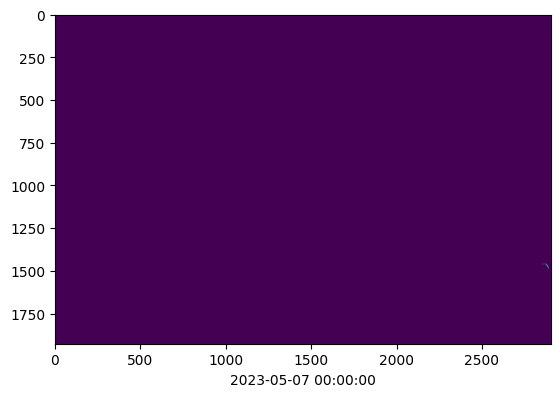

 79%|███████▊  | 88/112 [02:30<00:30,  1.27s/it]

0.0


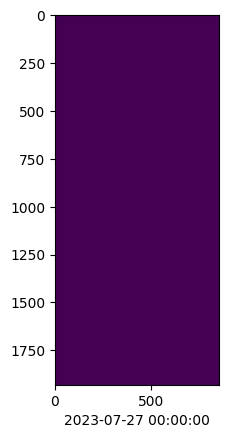

 79%|███████▉  | 89/112 [02:31<00:27,  1.19s/it]

9.231488420027858


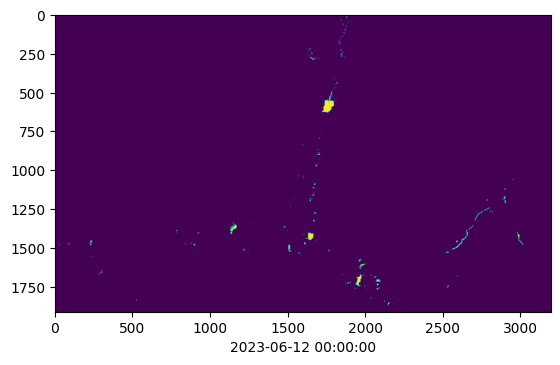

 80%|████████  | 90/112 [02:33<00:29,  1.34s/it]

0.0


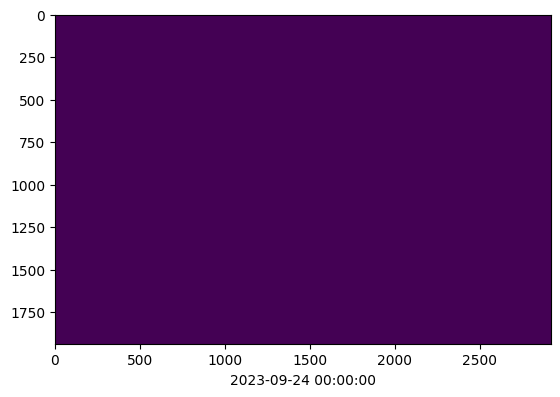

 81%|████████▏ | 91/112 [02:35<00:31,  1.51s/it]

0.0


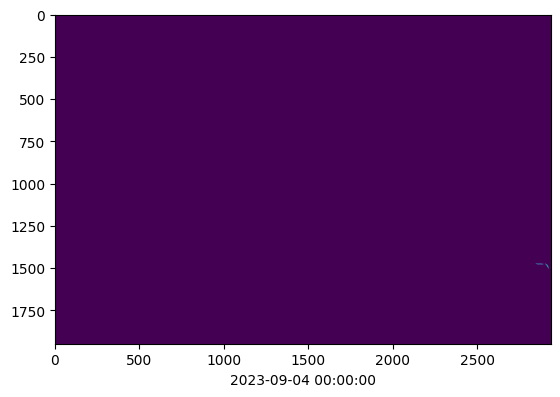

 82%|████████▏ | 92/112 [02:36<00:29,  1.47s/it]

15.451561112981476


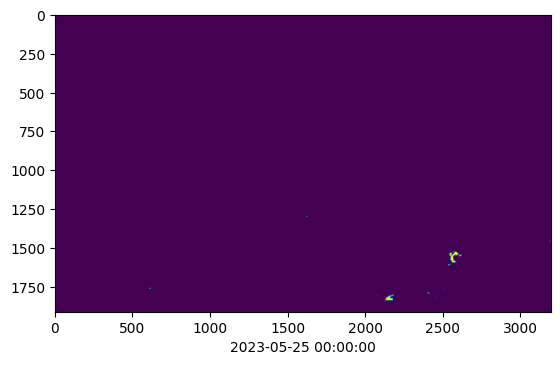

 83%|████████▎ | 93/112 [02:39<00:34,  1.81s/it]

2.6669219665296175


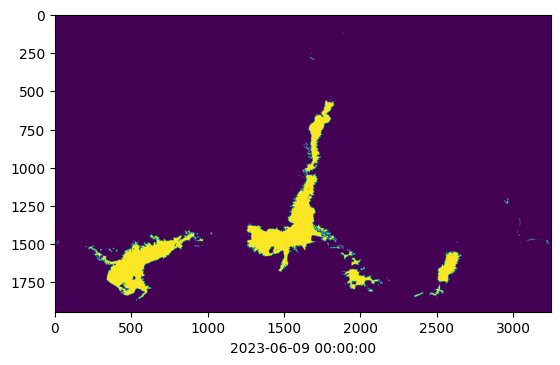

 84%|████████▍ | 94/112 [02:40<00:31,  1.77s/it]

0.0


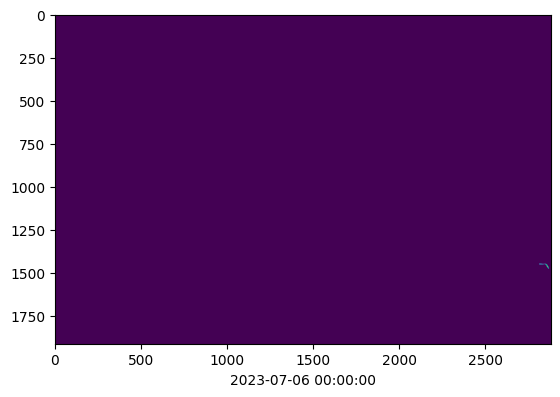

 85%|████████▍ | 95/112 [02:42<00:27,  1.65s/it]

0.0


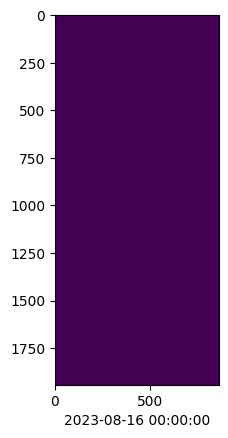

 86%|████████▌ | 96/112 [02:42<00:22,  1.38s/it]

2.0275674651230773


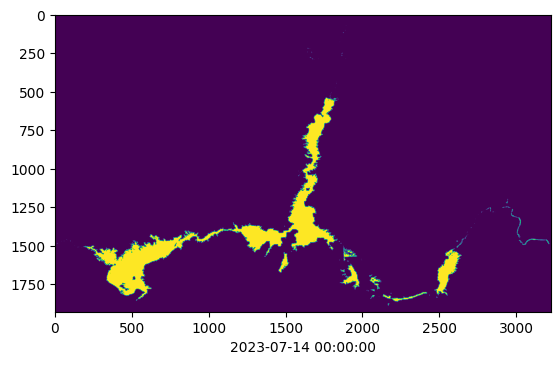

 87%|████████▋ | 97/112 [02:44<00:23,  1.57s/it]

0.052626139938108545


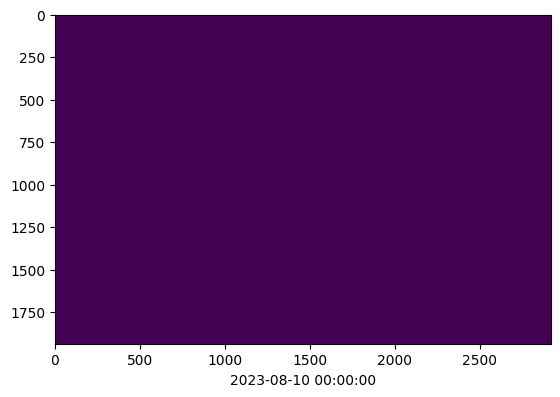

 88%|████████▊ | 98/112 [02:46<00:23,  1.65s/it]

0.0


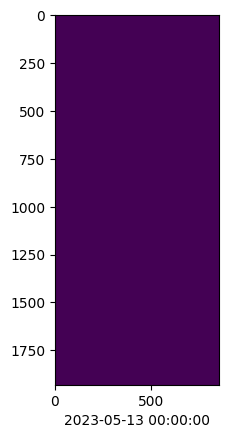

 88%|████████▊ | 99/112 [02:47<00:18,  1.45s/it]

1.62863082308952


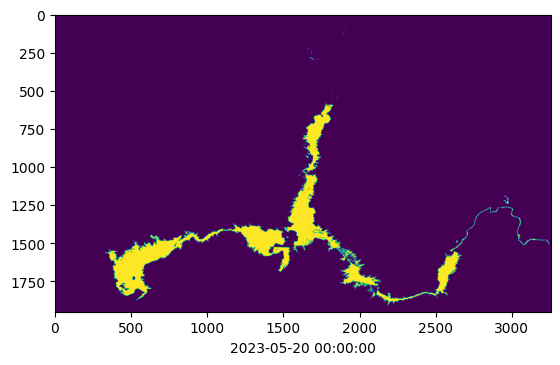

 89%|████████▉ | 100/112 [02:50<00:20,  1.74s/it]

0.0


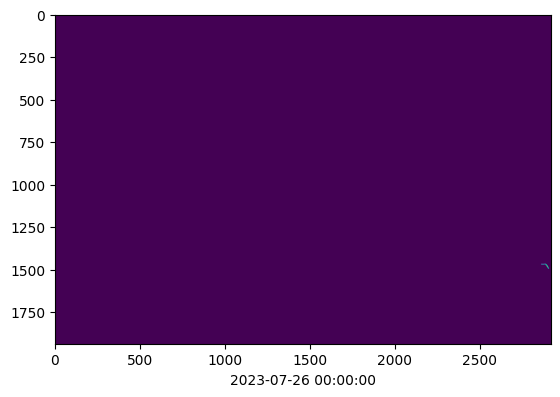

 90%|█████████ | 101/112 [02:51<00:17,  1.63s/it]

0.0


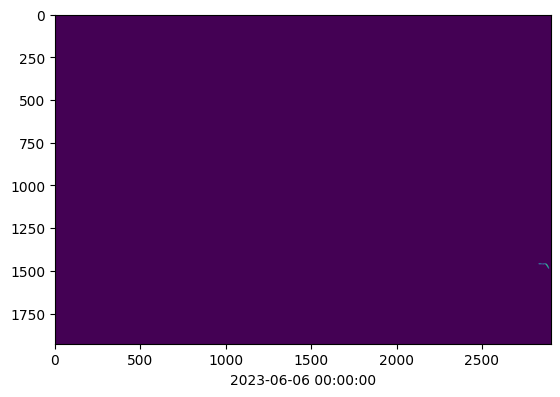

 91%|█████████ | 102/112 [02:52<00:14,  1.48s/it]

0.0


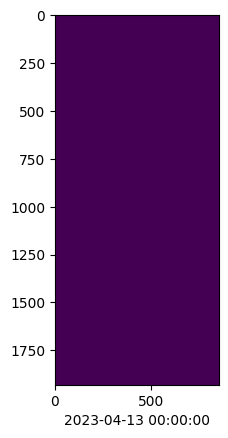

 92%|█████████▏| 103/112 [02:53<00:12,  1.41s/it]

0.0


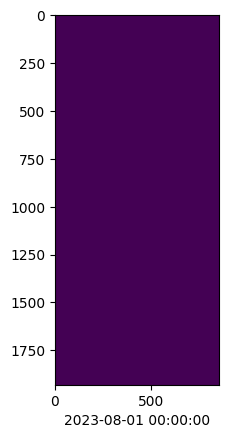

 93%|█████████▎| 104/112 [02:55<00:10,  1.35s/it]

0.714330287188163


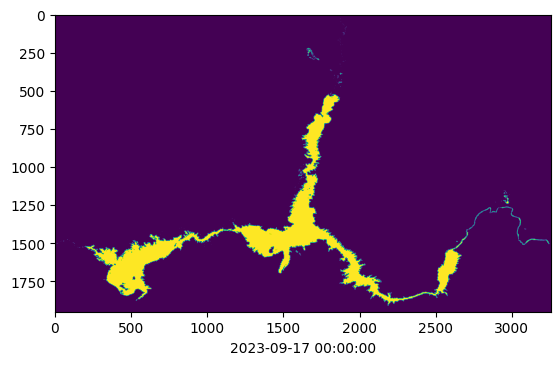

 94%|█████████▍| 105/112 [02:58<00:14,  2.06s/it]

1.1481948330741985


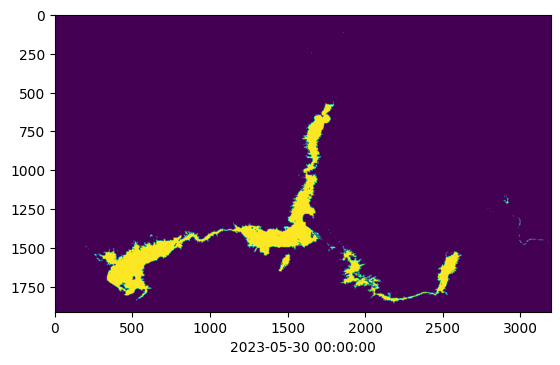

 95%|█████████▍| 106/112 [03:00<00:11,  1.98s/it]

0.0


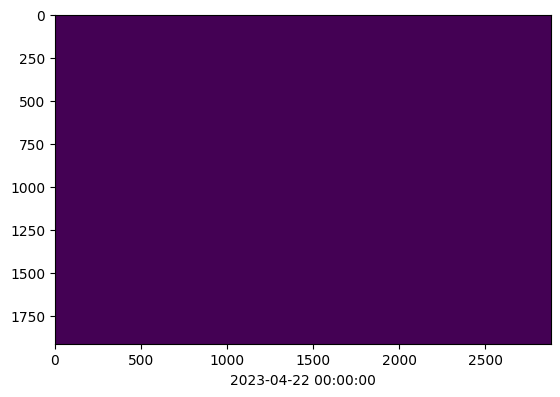

 96%|█████████▌| 107/112 [03:01<00:08,  1.74s/it]

0.7259377205903683


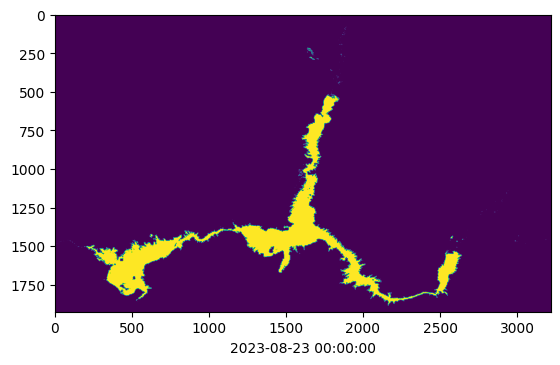

 96%|█████████▋| 108/112 [03:04<00:07,  1.96s/it]

0.0


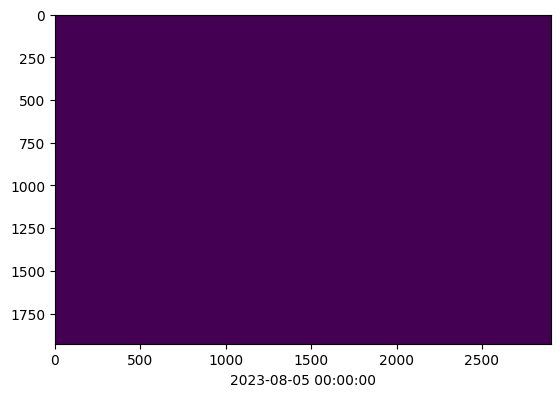

 97%|█████████▋| 109/112 [03:05<00:05,  1.74s/it]

0.0


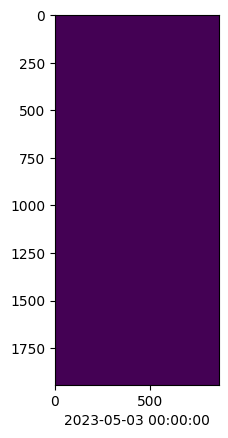

 98%|█████████▊| 110/112 [03:06<00:02,  1.43s/it]

0.0


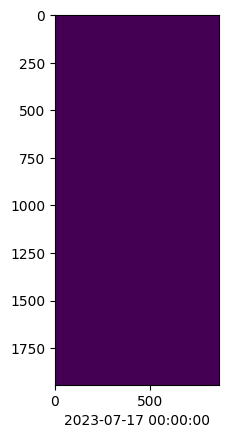

 99%|█████████▉| 111/112 [03:06<00:01,  1.21s/it]

0.04142127818243112


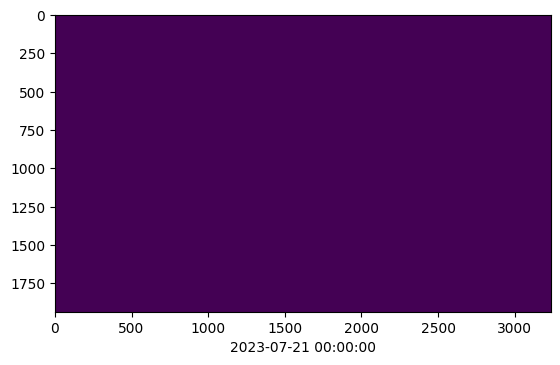

100%|██████████| 112/112 [03:09<00:00,  1.69s/it]


In [53]:
k = 0
date = []
area = []
for f in tqdm(all_files):
    try:
        # Load the raster
        with rio.open(os.path.join(dirpath,f)) as src:
            # Clip the raster using the geometry from the GeoDataFrame
            out_image, out_transform = mask(src, [gdf.geometry.values[0].__geo_interface__], crop=True)
            out_meta = src.meta.copy()
        
        # Update the metadata with the new clipped raster details
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # Save the clipped raster to a new file
        with rio.open('clipped_raster.tif', 'w', **out_meta) as dest:
            dest.write(out_image)
        
        res = rio.open('clipped_raster.tif').read(1)
        cl_cov = res[res==253].shape[0]/res[res>=0].shape[0]*100
        print(cl_cov)
        res[res!=1] = 0
        plt.xlabel(res[res==1].shape[0]*900/10**6)
        plt.imshow(res)
        plt.xlabel(datetime.strptime(f.split('_')[1].split('.')[0],'%Y-%m-%d %H:%M:%S'))
        plt.show()

        date.append(datetime.strptime(f.split('_')[1].split('.')[0],'%Y-%m-%d %H:%M:%S'))
        area.append(res[res==1].shape[0]*900/10**6)
    except ValueError as e:
        # Check if the error is due to non-overlapping shapes
        if "Input shapes do not overlap raster" in str(e):
            print(f"Skipping {f} as it does not overlap with the input shape.")
            continue
        else:
            raise e  
    # if k == 10:
    #     break
    # k = k + 1

In [24]:
hls_df = pd.read_csv(str(res_idx)+'_f.csv')
hls_df['date'] = pd.to_datetime(hls_df['date'], format='%Y%j')
hls_df

Unnamed: 0       date  terrain_area  enh_area1  enh_area2  threshold  \
0           201 2016-01-07      295.2774   350.9019   364.8294       97.0   
1           526 2016-01-16       22.4226   296.1234   317.1204       98.0   
2           593 2016-02-01        0.7677   301.3227   345.0699       97.0   
3           320 2016-02-06      333.3987   333.3987   333.3987        NaN   
4           130 2016-02-16      333.3762   333.3762   333.3762        NaN   
..          ...        ...           ...        ...        ...        ...   
648         464 2023-06-28      211.7556   211.7556   211.7556        NaN   
649          67 2023-06-29      291.6954   291.6954   291.6954        NaN   
650          10 2023-07-04      290.6658   290.6658   290.6658        NaN   
651         788 2023-07-06      213.2451   213.2451   213.2451        NaN   
652         290 2023-07-09      251.7804   303.5862   319.5972       98.0   

     elbow  cloud_cover    datetime  days    smoothed  rolling_std  lake_area  
0     83.0    11.080869  2016-01-07   -30  334.794392     3.347944        NaN  
1     92.0    37.150371  2016-01-16   -21  334.794392     3.347944        NaN  
2     75.0    49.577506  2016-02-01    -5  334.794392     3.347944        NaN  
3      NaN     0.371898  2016-02-06     0  334.794392     3.347944   333.3987  
4      NaN     0.395655  2016-02-16    10  333.542654     3.335427   333.3762  
..     ...          ...         ...   ...         ...          ...        ...  
648    NaN     0.029057  2023-06-28  2699  291.796719     2.917967        NaN  
649    NaN     0.801858  2023-06-29  2700  292.001643     2.920016   291.6954  
650    NaN     0.150670  2023-07-04  2705  293.023227     2.930232   290.6658  
651    NaN     0.027583  2023-07-06  2707  293.430868     2.934309        NaN  
652   92.0     3.864531  2023-07-09  2710  294.042329     2.940423        NaN  

[653 rows x 13 columns]

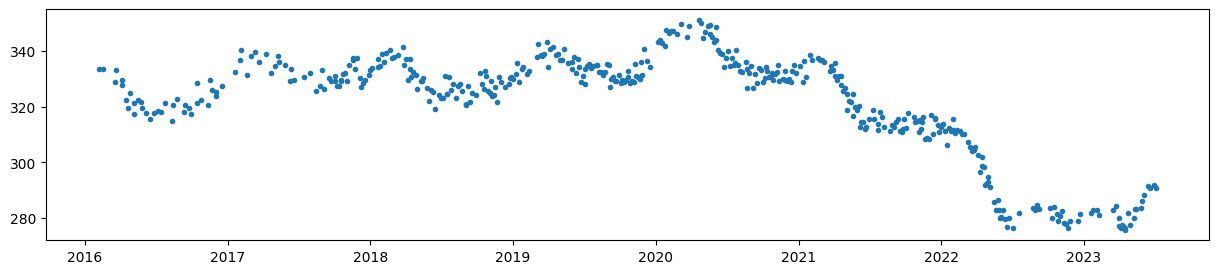

In [48]:
plt.figure(figsize=(15,3))
plt.plot(hls_df['date'],hls_df['lake_area'],'.')

In [55]:
d_ = []
a_ = []
for i in range(len(area)):
    if area[i]>=0:
        a_.append(area[i])
        d_.append(date[i])

In [39]:
new_df = hls_df[hls_df['date']>datetime(2022,1,1)]

In [41]:
in_situ = pd.read_csv('383_in_situ.csv')
in_situ

Unnamed: 0      date        area      storage      depth agency qaqc
0     LAKE MEAD  20160101  329.491848  336905546.5  36.959124   RPVD    O
1     LAKE MEAD  20160102  329.528424  337073376.9  36.977316   RPVD    O
2     LAKE MEAD  20160103  329.558904  337213235.5  36.992706   RPVD    O
3     LAKE MEAD  20160104  329.568048  337255193.1  36.997247   RPVD    O
4     LAKE MEAD  20160105  329.613768  337464981.2  37.019936   RPVD    O
...         ...       ...         ...          ...        ...    ...  ...
2187  LAKE MEAD  20211227  324.953376  316168307.4  34.698399   RPVD    O
2188  LAKE MEAD  20211228  324.962520  316209612.3  34.702995   RPVD    O
2189  LAKE MEAD  20211229  324.968616  316237148.9  34.706058   RPVD    O
2190  LAKE MEAD  20211230  324.974712  316264685.6  34.709120   RPVD    O
2191  LAKE MEAD  20211231  325.035672  316540051.7  34.739793   RPVD    O

[2192 rows x 7 columns]

In [59]:
print(len(a_))
a_ = np.array(a_)
print(len(a_[a_>0]))

112
66


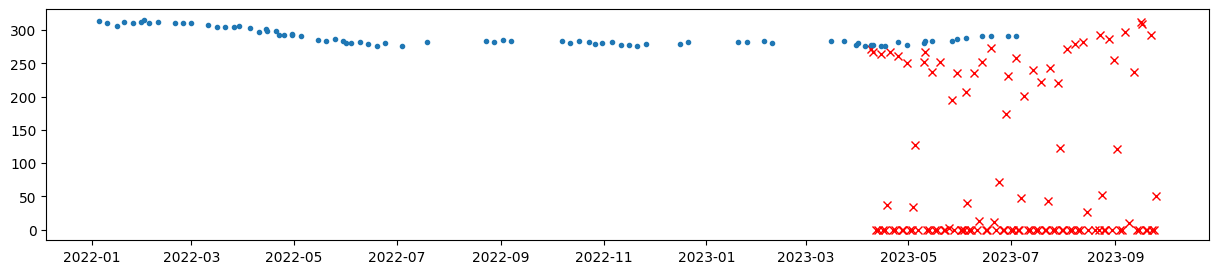

In [56]:
plt.figure(figsize=(15,3))
plt.plot(d_, a_,'rx')
plt.plot(new_df['date'], new_df['lake_area'],'.')

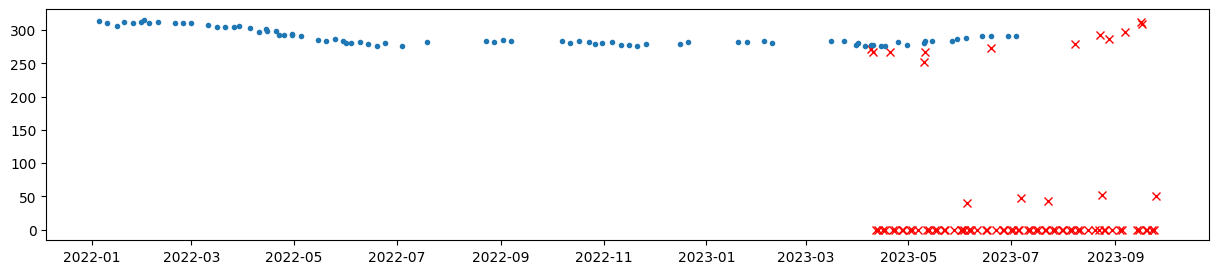

In [50]:
plt.figure(figsize=(15,3))
plt.plot(d_, a_,'rx')
plt.plot(new_df['date'], new_df['lake_area'],'.')

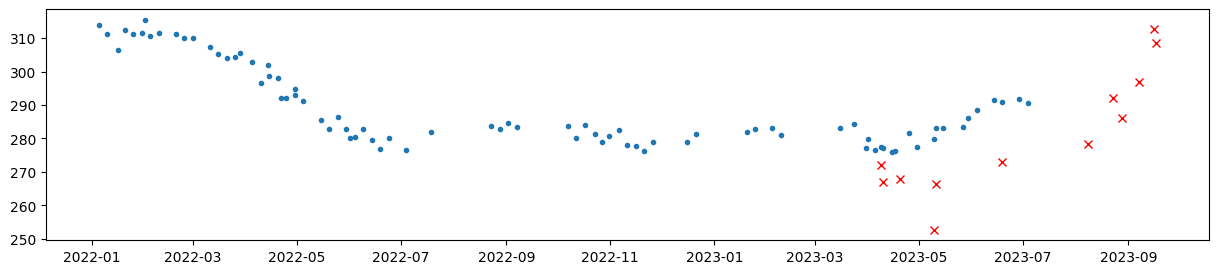

In [46]:
plt.figure(figsize=(15,3))
plt.plot(d_, a_,'rx')
plt.plot(new_df['date'], new_df['lake_area'],'.')

## Small lake

In [60]:
res_idx = 189

In [61]:
# Specify the directory path
dirpath = 'opera_data/'+str(res_idx)+'_merged'

# List all files in the directory
all_files = os.listdir(dirpath)

  0%|          | 0/81 [00:00<?, ?it/s]

0.0


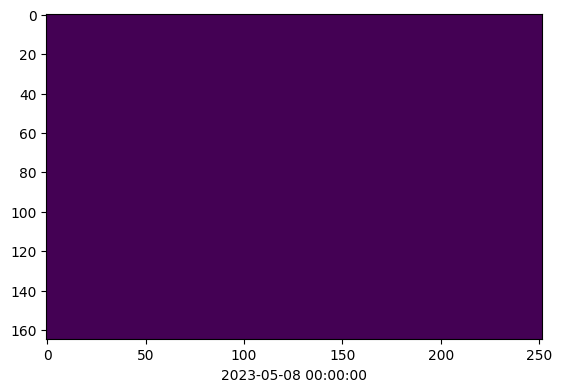

  1%|          | 1/81 [00:00<00:48,  1.64it/s]

49.30487804878049


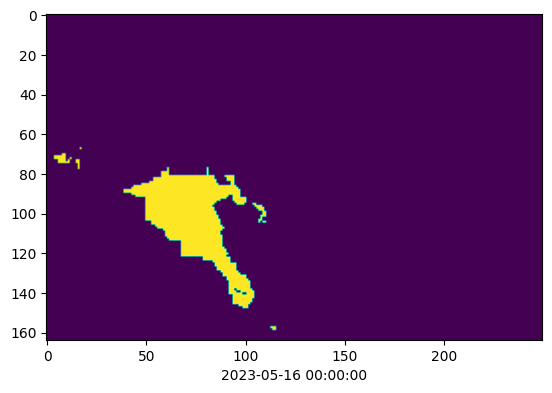

  2%|▏         | 2/81 [00:01<00:44,  1.78it/s]

17.041463414634148


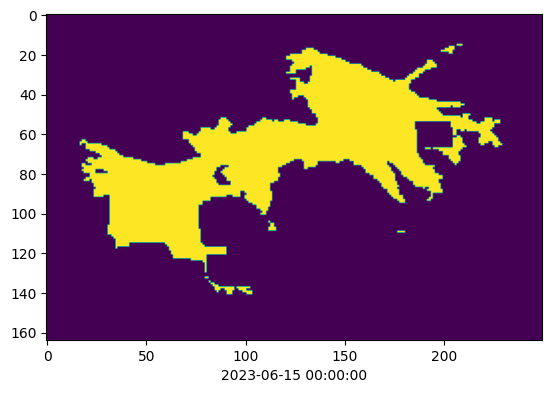

  4%|▎         | 3/81 [00:01<00:41,  1.86it/s]

58.080808080808076


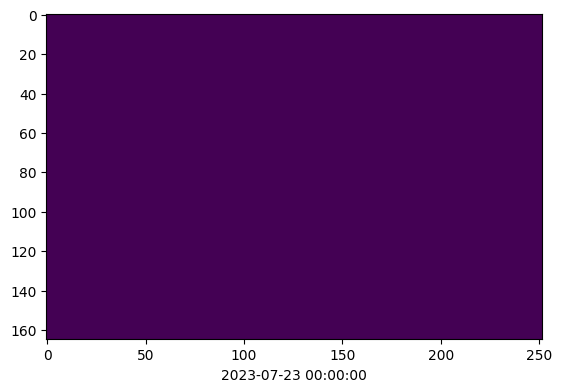

  5%|▍         | 4/81 [00:02<00:42,  1.83it/s]

0.0


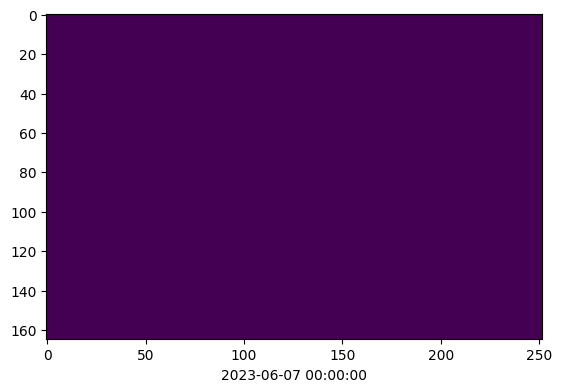

  6%|▌         | 5/81 [00:02<00:40,  1.89it/s]

58.080808080808076


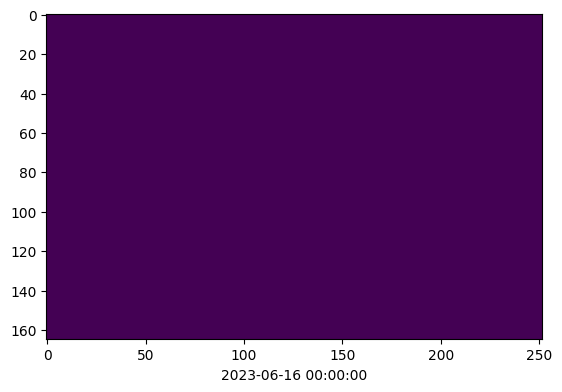

  7%|▋         | 6/81 [00:03<00:38,  1.94it/s]

0.0


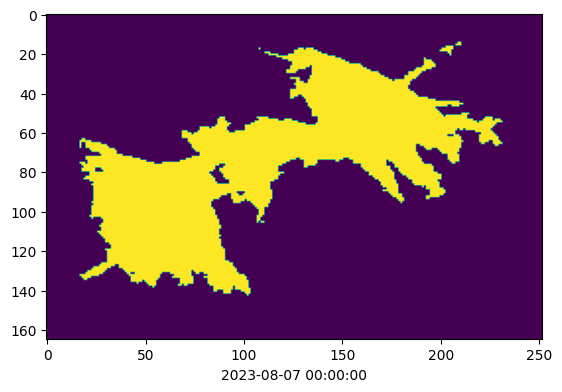

  9%|▊         | 7/81 [00:03<00:40,  1.83it/s]

0.9499759499759499


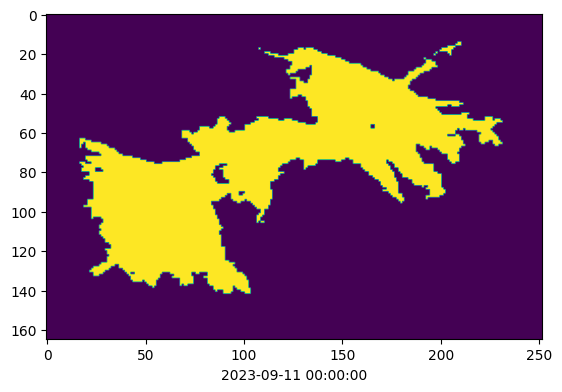

 10%|▉         | 8/81 [00:04<00:41,  1.78it/s]

0.0


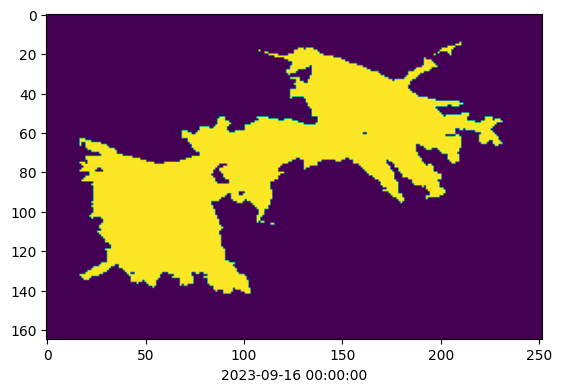

 11%|█         | 9/81 [00:05<00:41,  1.72it/s]

2.0073170731707317


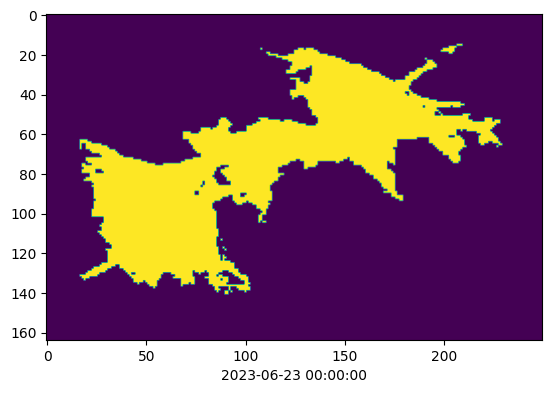

 12%|█▏        | 10/81 [00:05<00:42,  1.67it/s]

0.18037518037518038


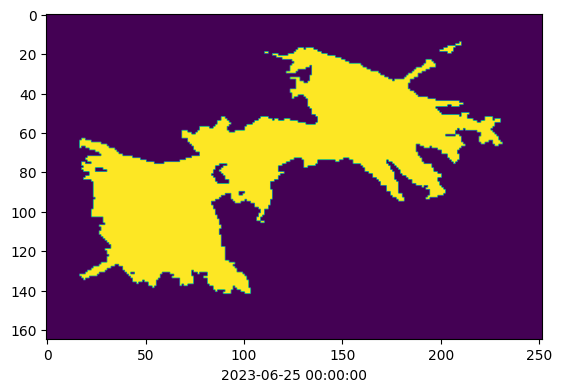

 14%|█▎        | 11/81 [00:06<00:41,  1.67it/s]

1.7652717652717653


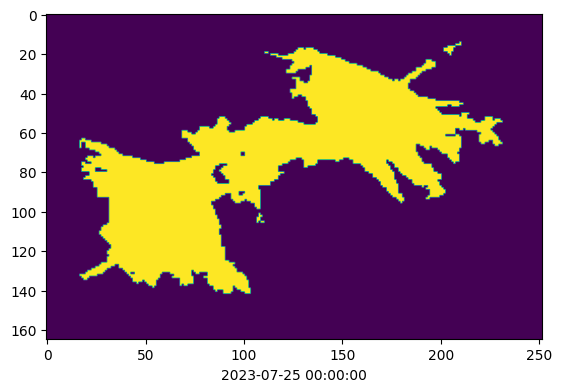

 15%|█▍        | 12/81 [00:06<00:41,  1.67it/s]

51.62926829268293


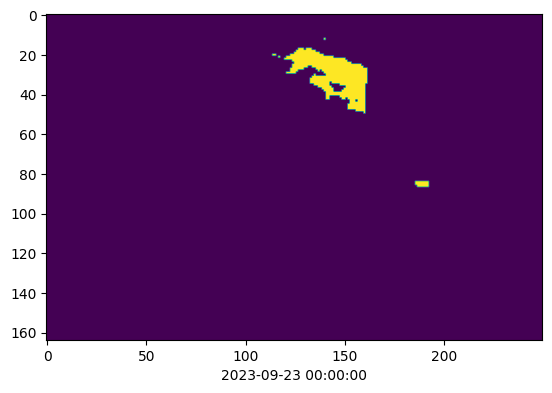

 16%|█▌        | 13/81 [00:07<00:40,  1.66it/s]

22.111592111592113


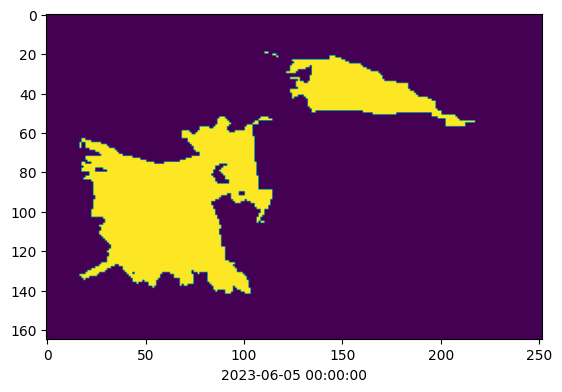

 17%|█▋        | 14/81 [00:07<00:38,  1.73it/s]

4.497560975609756


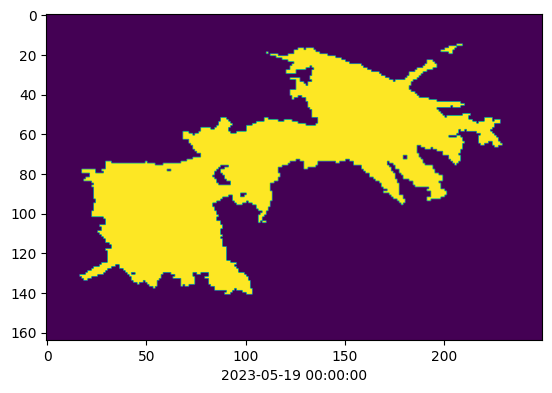

 20%|█▉        | 16/81 [00:08<00:28,  2.26it/s]

Skipping merged_2023-05-14 00:00:00.tif as it does not overlap with the input shape.
2.8975609756097565


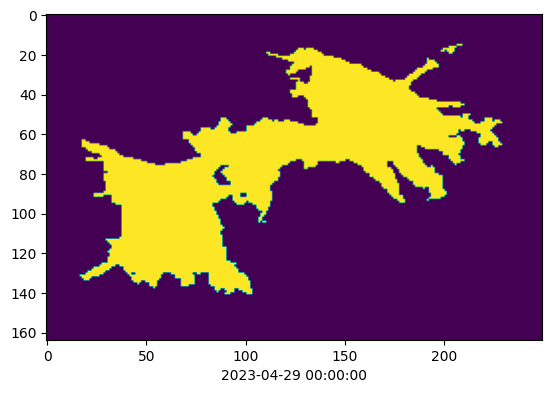

 21%|██        | 17/81 [00:09<00:31,  2.05it/s]

0.0


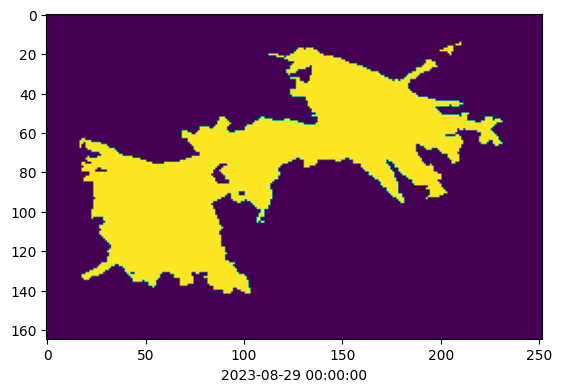

 22%|██▏       | 18/81 [00:10<00:38,  1.65it/s]

0.0


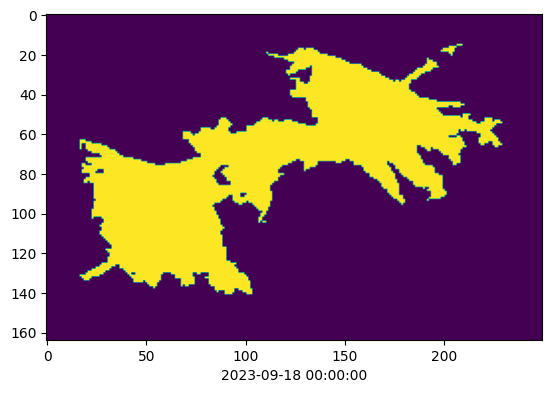

 23%|██▎       | 19/81 [00:10<00:38,  1.61it/s]

8.81951219512195


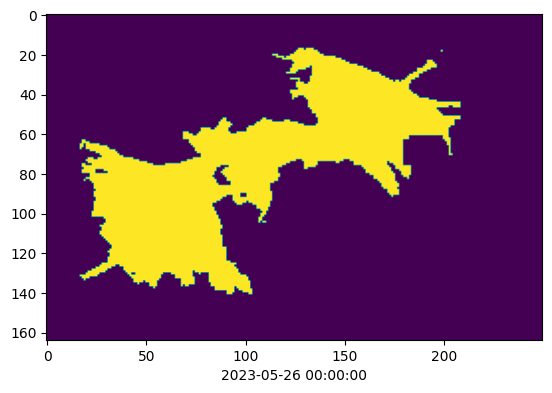

 25%|██▍       | 20/81 [00:11<00:37,  1.61it/s]

0.0


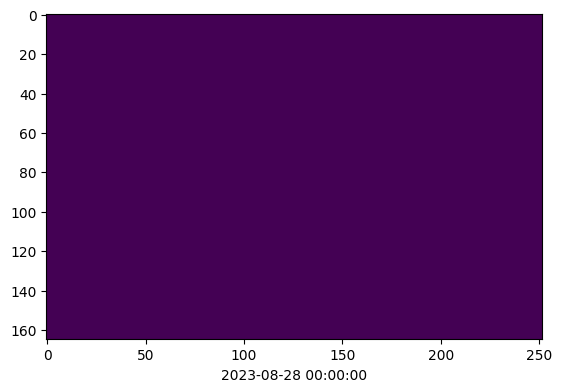

 26%|██▌       | 21/81 [00:12<00:38,  1.57it/s]

4.143819143819144


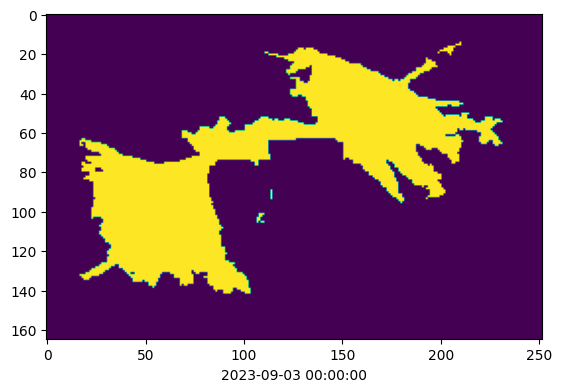

 27%|██▋       | 22/81 [00:12<00:37,  1.56it/s]

57.74634146341463


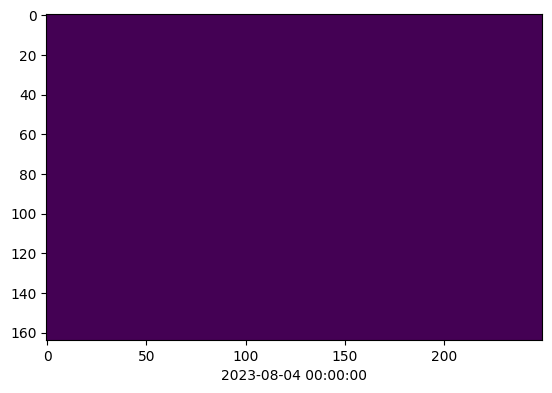

 28%|██▊       | 23/81 [00:13<00:36,  1.60it/s]

0.0


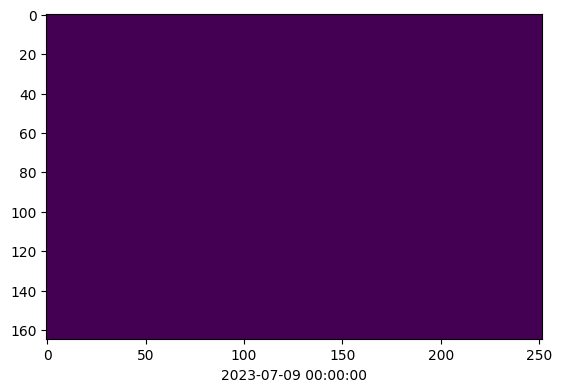

 30%|██▉       | 24/81 [00:13<00:35,  1.63it/s]

2.324390243902439


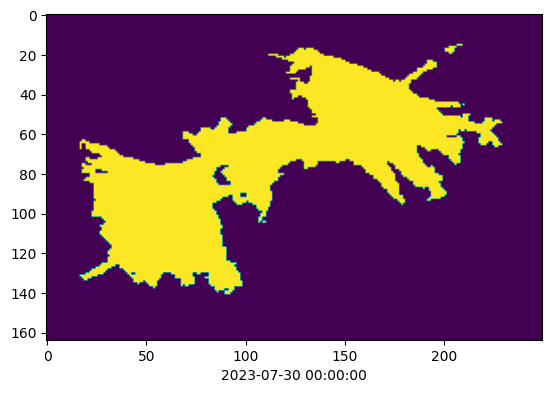

 31%|███       | 25/81 [00:14<00:33,  1.69it/s]

0.0


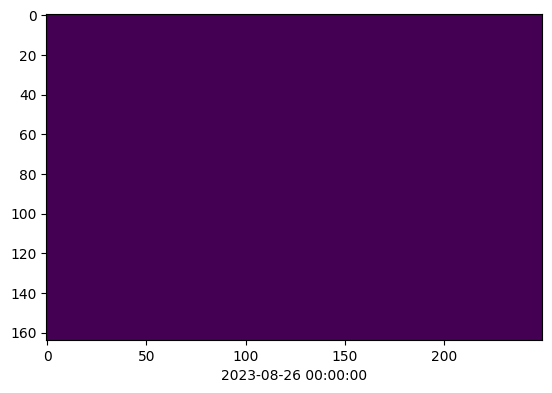

 32%|███▏      | 26/81 [00:15<00:32,  1.70it/s]

0.0


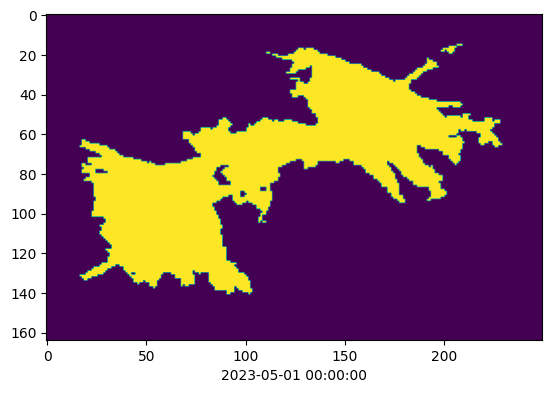

 33%|███▎      | 27/81 [00:15<00:32,  1.68it/s]

0.0


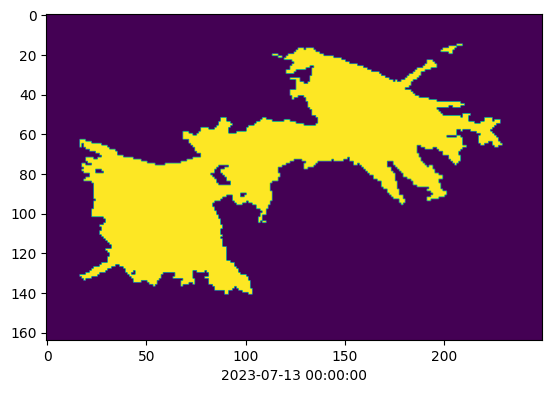

 35%|███▍      | 28/81 [00:16<00:29,  1.80it/s]

39.12698412698413


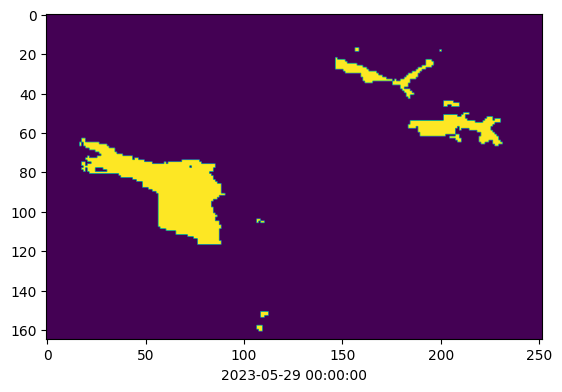

 36%|███▌      | 29/81 [00:16<00:28,  1.84it/s]

6.575276575276575


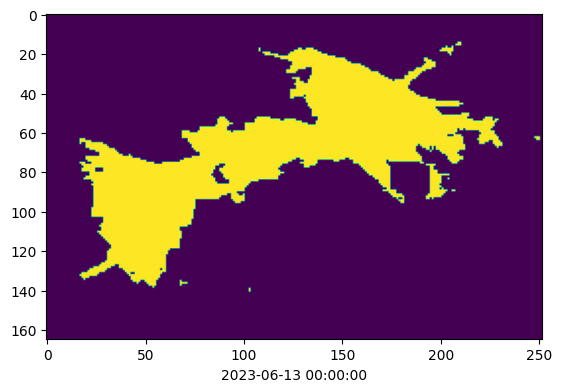

 37%|███▋      | 30/81 [00:17<00:28,  1.81it/s]

0.0


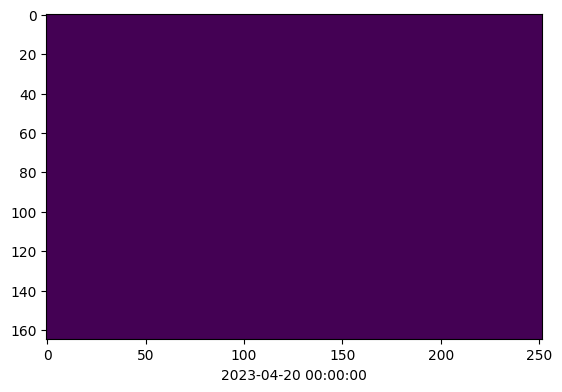

 38%|███▊      | 31/81 [00:17<00:26,  1.87it/s]

0.0


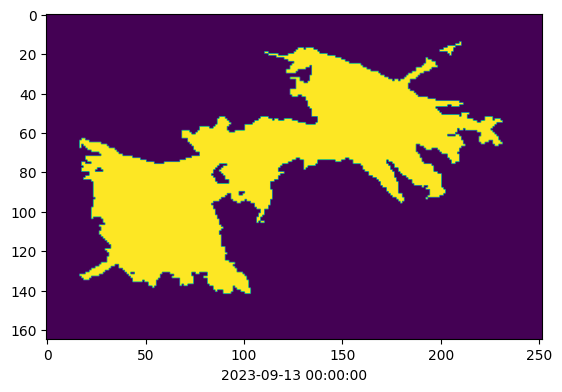

 40%|███▉      | 32/81 [00:18<00:25,  1.95it/s]

57.06341463414633


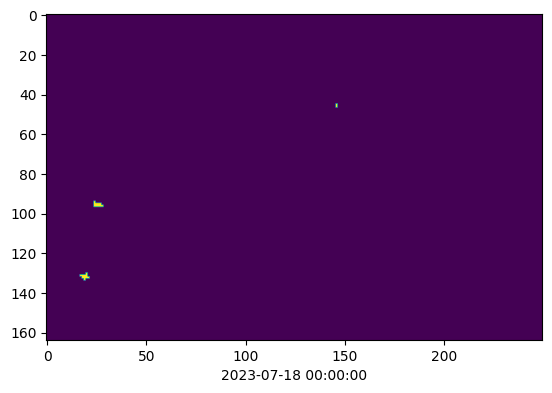

 41%|████      | 33/81 [00:18<00:25,  1.88it/s]

58.080808080808076


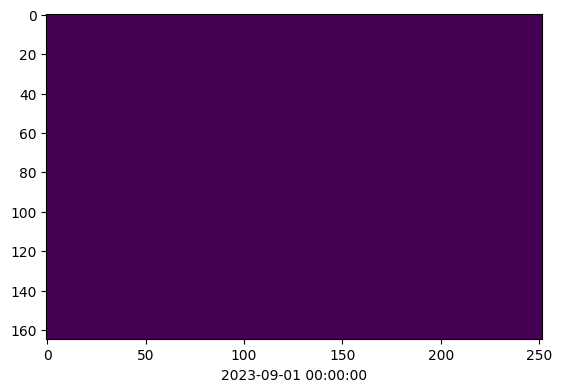

 42%|████▏     | 34/81 [00:19<00:24,  1.91it/s]

6.1414634146341465


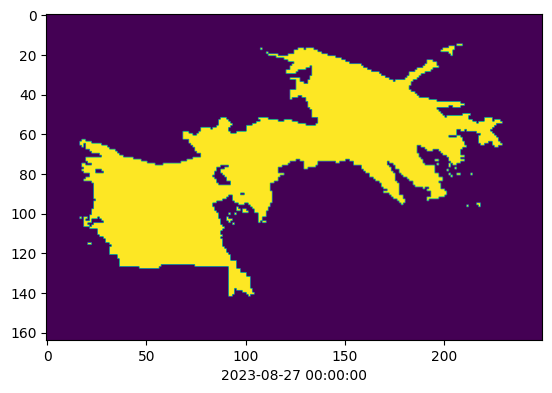

 43%|████▎     | 35/81 [00:19<00:24,  1.91it/s]

58.080808080808076


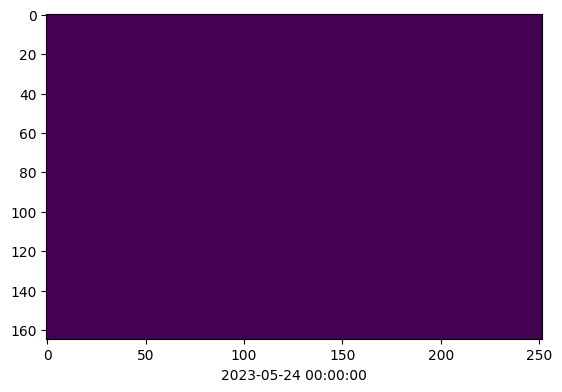

 44%|████▍     | 36/81 [00:20<00:23,  1.88it/s]

3.5040885040885037


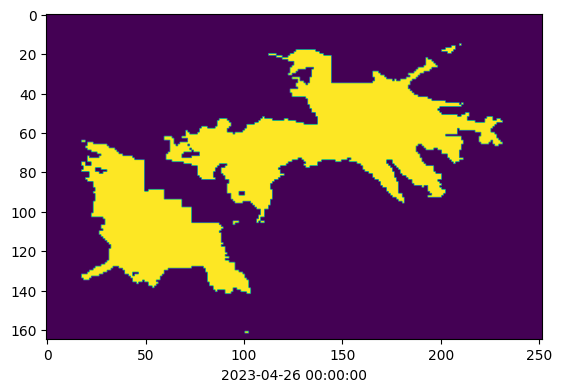

 46%|████▌     | 37/81 [00:20<00:24,  1.82it/s]

0.0


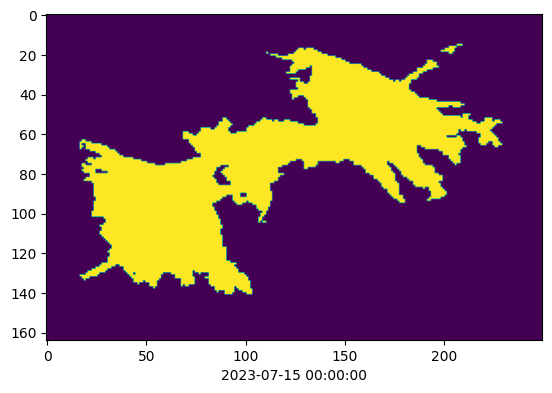

 47%|████▋     | 38/81 [00:21<00:24,  1.73it/s]

11.34390243902439


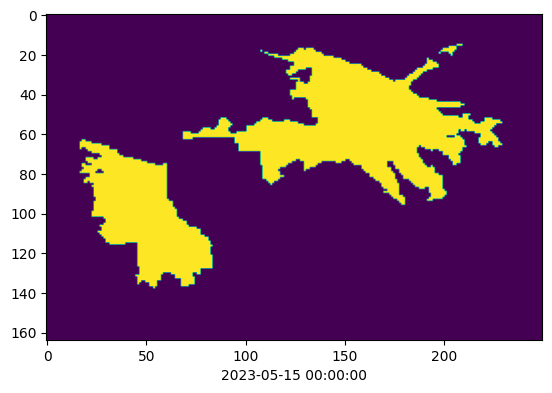

 48%|████▊     | 39/81 [00:22<00:24,  1.69it/s]

0.0


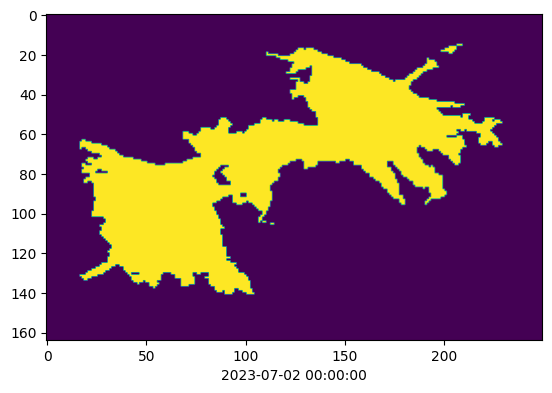

 49%|████▉     | 40/81 [00:22<00:24,  1.70it/s]

1.1592111592111594


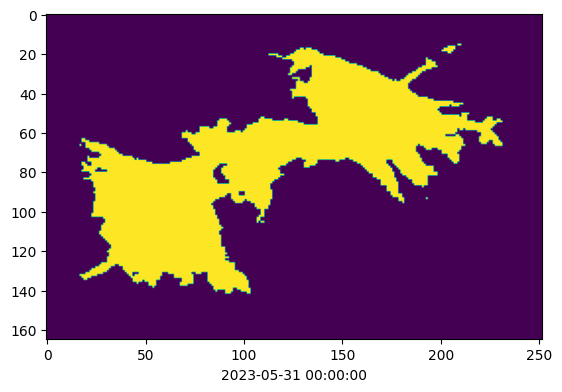

 51%|█████     | 41/81 [00:23<00:23,  1.72it/s]

20.7390243902439


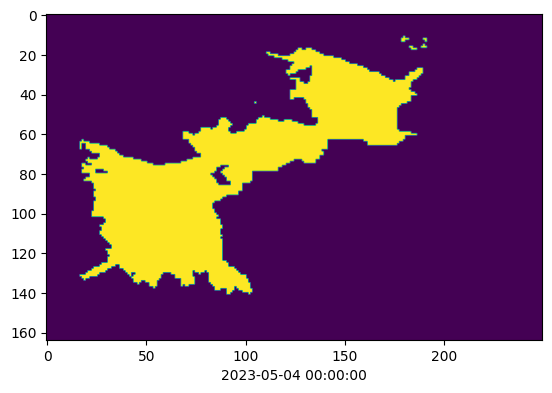

 52%|█████▏    | 42/81 [00:23<00:22,  1.77it/s]

0.0


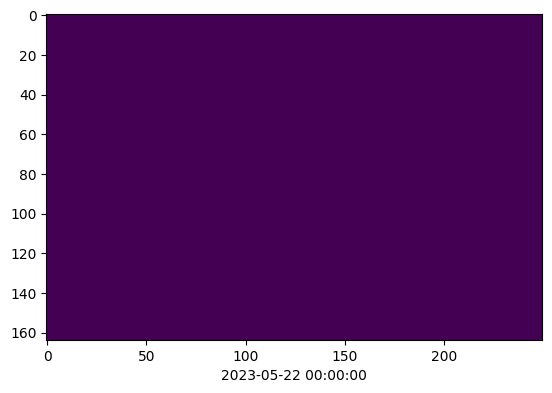

 53%|█████▎    | 43/81 [00:24<00:21,  1.80it/s]

57.74634146341463


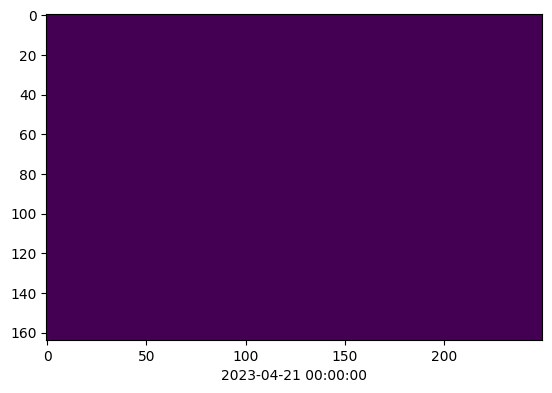

 54%|█████▍    | 44/81 [00:24<00:20,  1.84it/s]

1.429268292682927


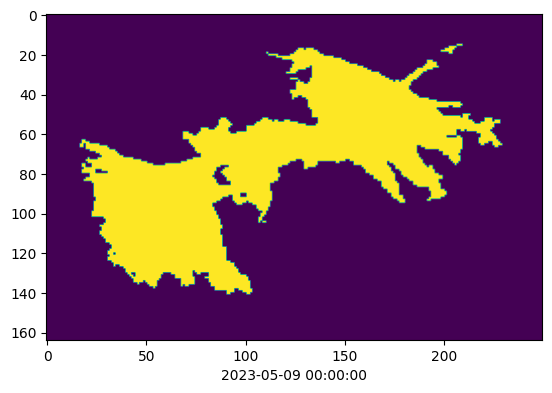

 56%|█████▌    | 45/81 [00:25<00:20,  1.80it/s]

0.0


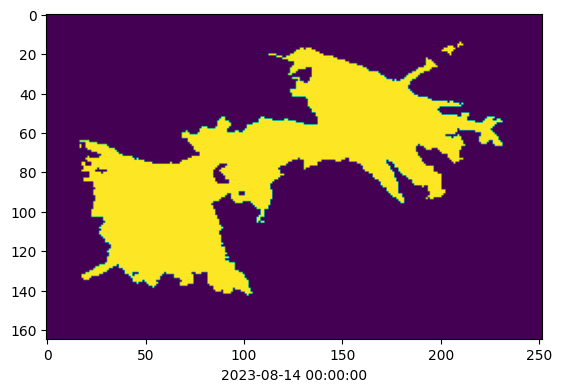

 58%|█████▊    | 47/81 [00:26<00:14,  2.40it/s]

Skipping merged_2023-07-20 00:00:00.tif as it does not overlap with the input shape.
28.484848484848484


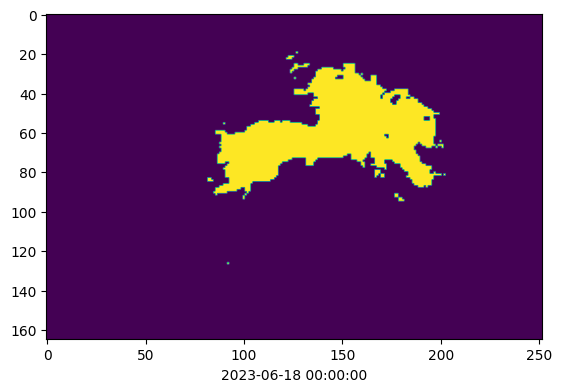

 59%|█████▉    | 48/81 [00:26<00:14,  2.21it/s]

6.71957671957672


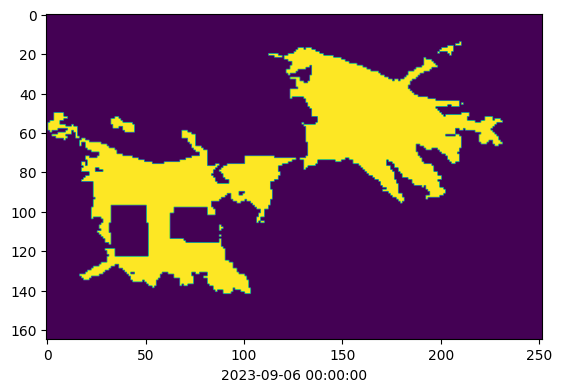

 60%|██████    | 49/81 [00:27<00:16,  1.99it/s]

0.0


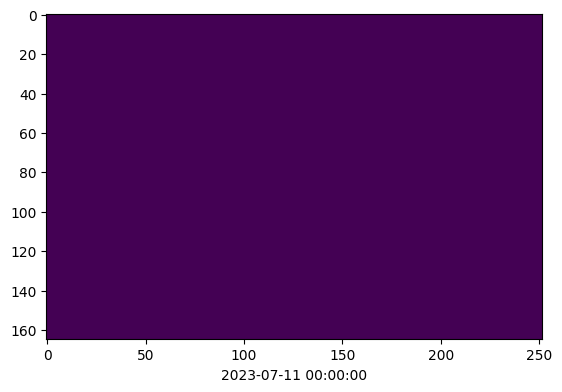

 62%|██████▏   | 50/81 [00:27<00:16,  1.89it/s]

57.74634146341463


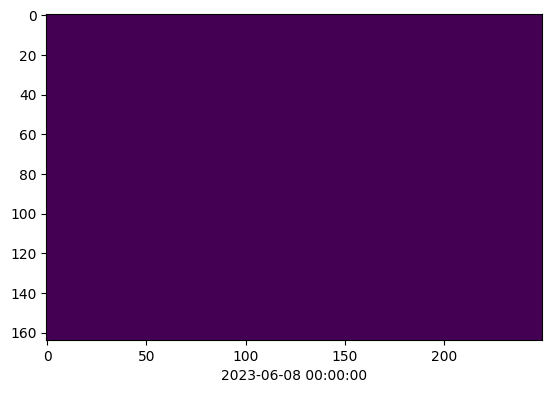

 63%|██████▎   | 51/81 [00:28<00:16,  1.79it/s]

0.0


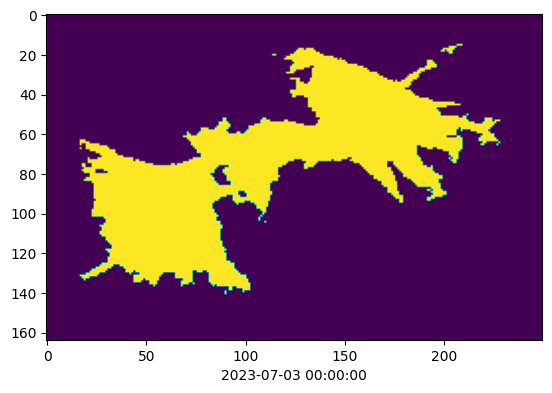

 64%|██████▍   | 52/81 [00:29<00:16,  1.78it/s]

4.5634146341463415


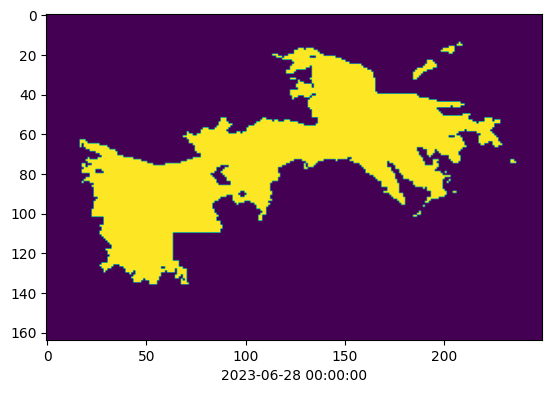

 65%|██████▌   | 53/81 [00:29<00:16,  1.73it/s]

54.129389129389125


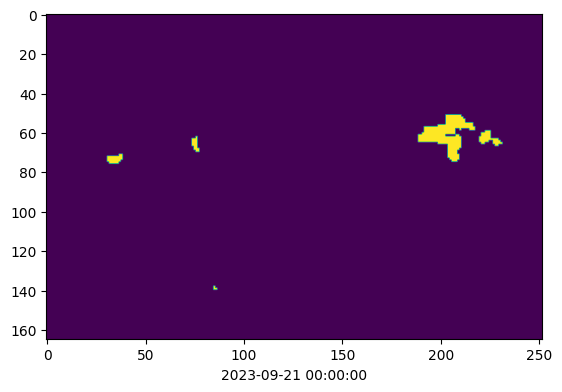

 67%|██████▋   | 54/81 [00:30<00:15,  1.76it/s]

58.080808080808076


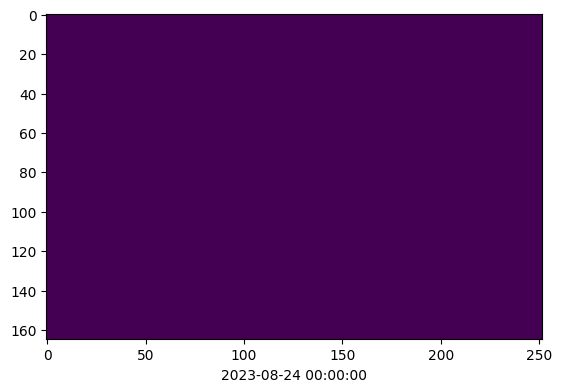

 68%|██████▊   | 55/81 [00:30<00:14,  1.85it/s]

0.0


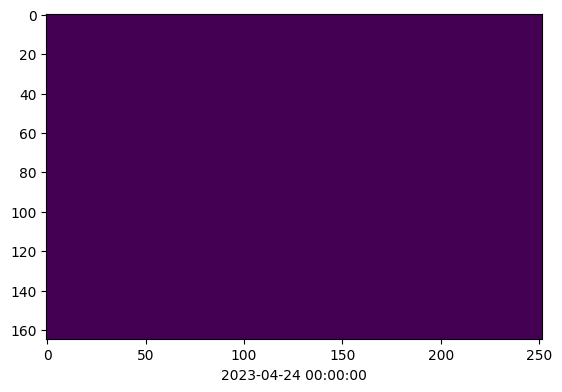

 69%|██████▉   | 56/81 [00:31<00:13,  1.89it/s]

0.0


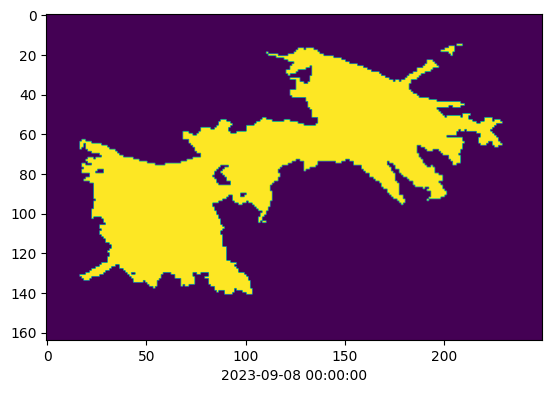

 70%|███████   | 57/81 [00:31<00:13,  1.82it/s]

57.21951219512194


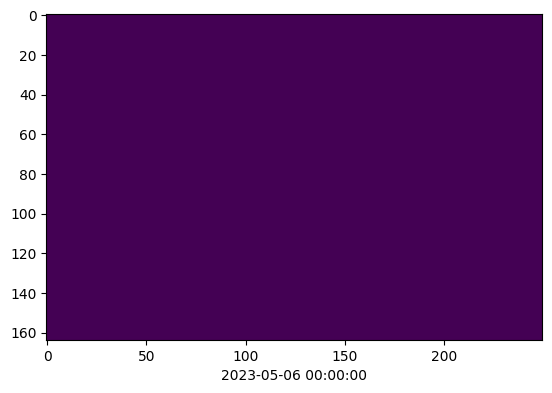

 72%|███████▏  | 58/81 [00:32<00:13,  1.75it/s]

0.0


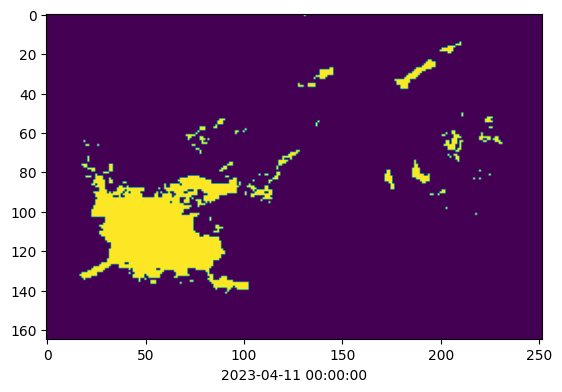

 73%|███████▎  | 59/81 [00:33<00:12,  1.70it/s]

0.0


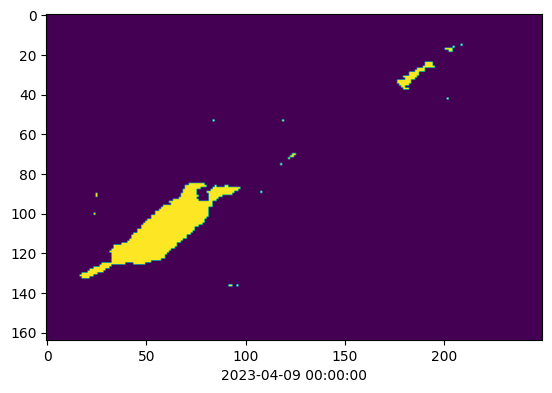

 74%|███████▍  | 60/81 [00:33<00:11,  1.80it/s]

57.74634146341463


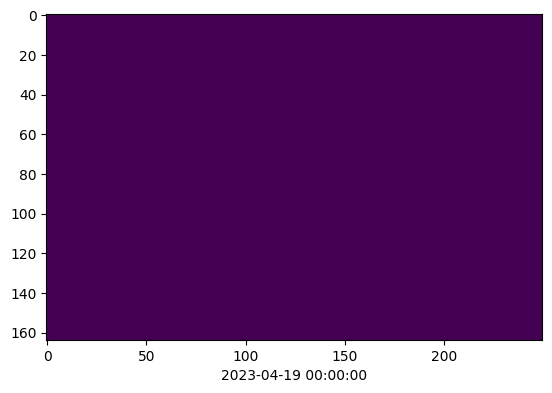

 75%|███████▌  | 61/81 [00:34<00:11,  1.77it/s]

55.85365853658537


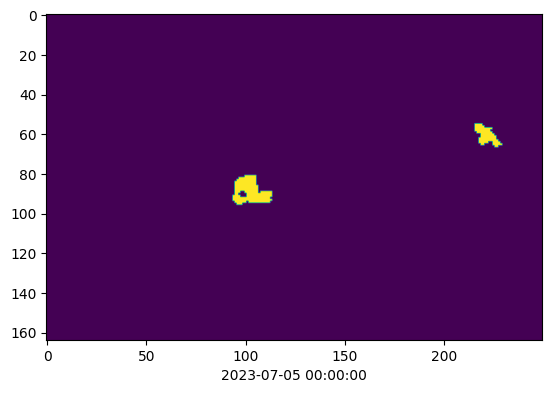

 77%|███████▋  | 62/81 [00:34<00:11,  1.72it/s]

57.74634146341463


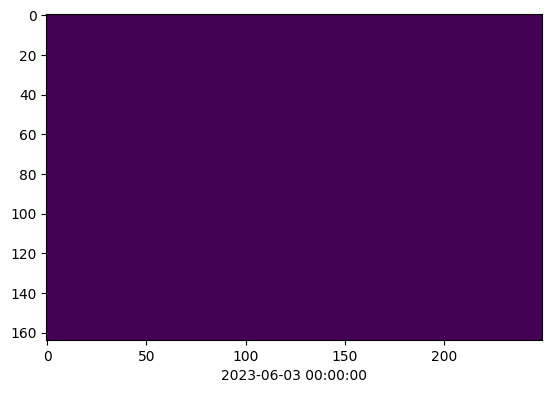

 78%|███████▊  | 63/81 [00:35<00:09,  1.82it/s]

0.48100048100048104


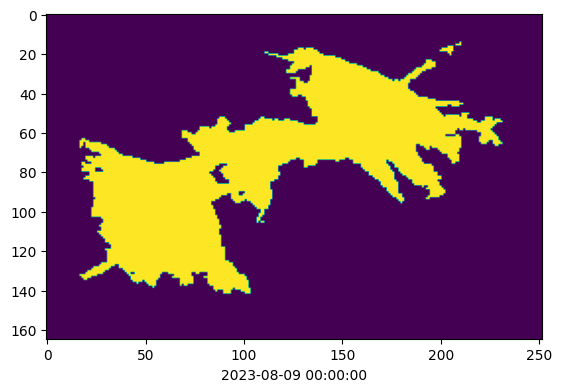

 79%|███████▉  | 64/81 [00:35<00:09,  1.77it/s]

1.524390243902439


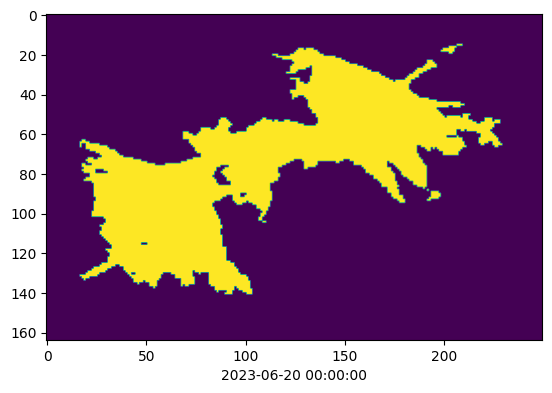

 80%|████████  | 65/81 [00:36<00:09,  1.77it/s]

1.1736411736411736


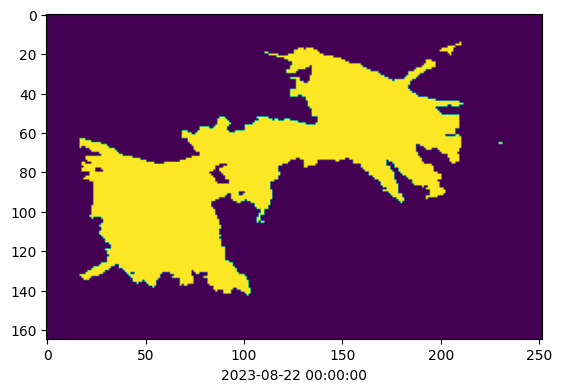

 81%|████████▏ | 66/81 [00:36<00:08,  1.80it/s]

0.0


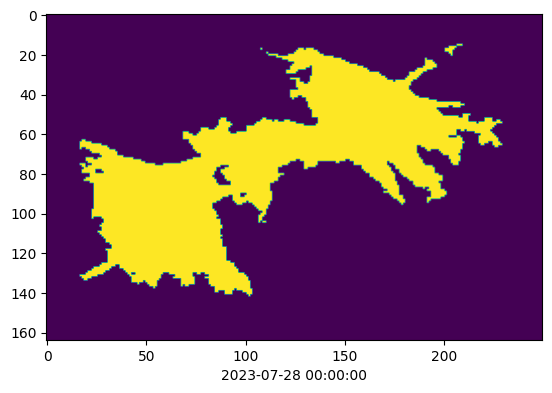

 83%|████████▎ | 67/81 [00:37<00:07,  1.89it/s]

58.080808080808076


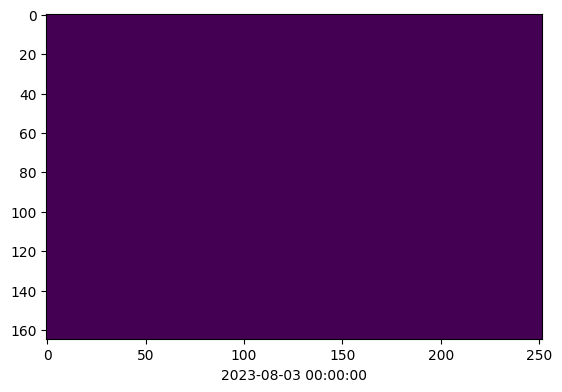

 84%|████████▍ | 68/81 [00:37<00:06,  1.95it/s]

0.0


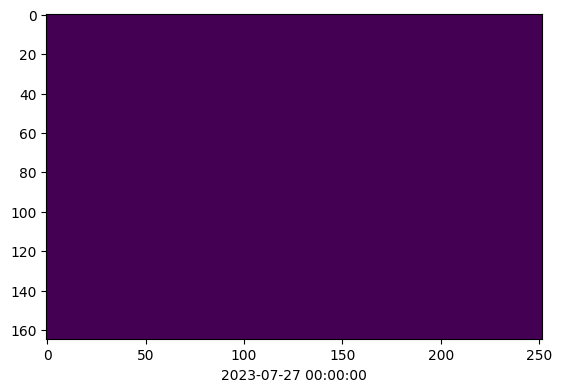

 85%|████████▌ | 69/81 [00:38<00:06,  1.98it/s]

0.0


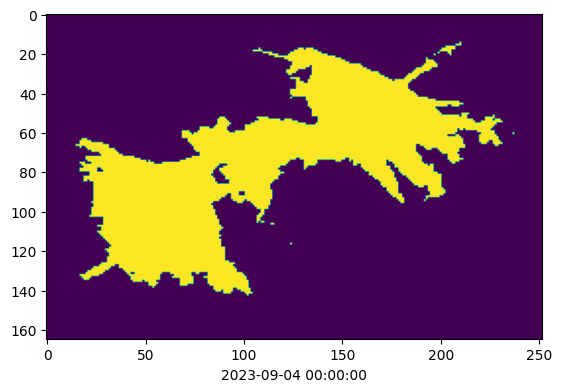

 86%|████████▋ | 70/81 [00:38<00:05,  2.00it/s]

57.74634146341463


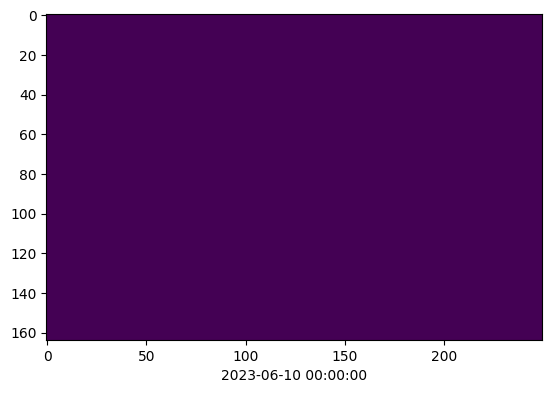

 88%|████████▊ | 71/81 [00:39<00:05,  1.87it/s]

56.98893698893699


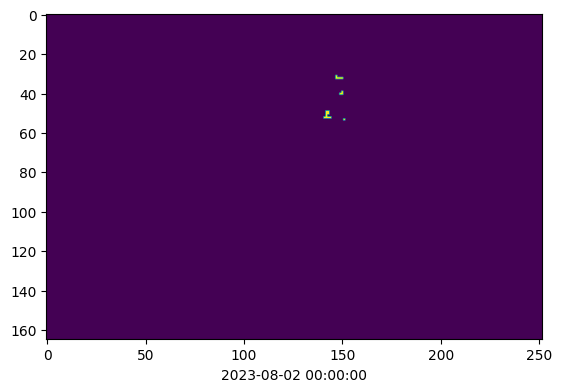

 89%|████████▉ | 72/81 [00:40<00:04,  1.86it/s]

0.0


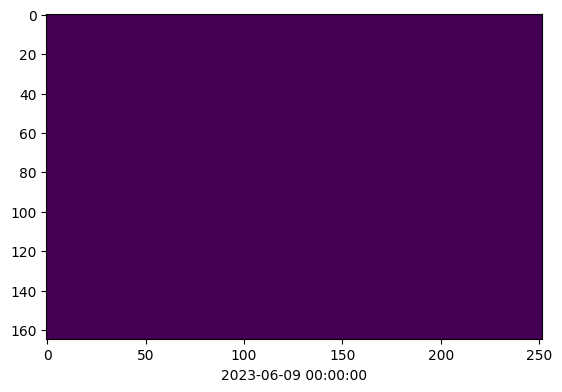

 90%|█████████ | 73/81 [00:40<00:04,  1.77it/s]

0.0


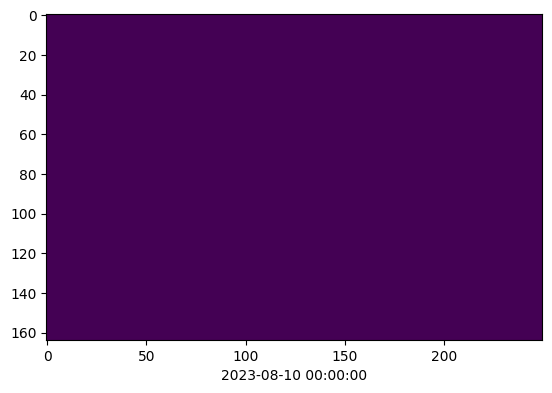

 91%|█████████▏| 74/81 [00:41<00:03,  1.78it/s]

0.6349206349206349


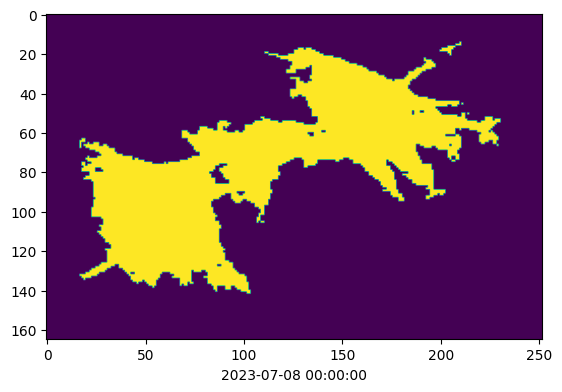

 93%|█████████▎| 75/81 [00:41<00:03,  1.84it/s]

57.527657527657524


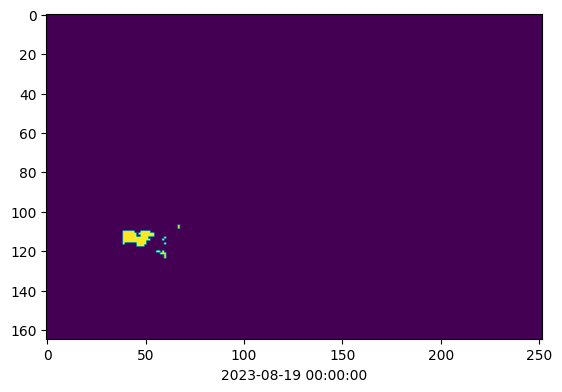

 94%|█████████▍| 76/81 [00:42<00:02,  1.88it/s]

58.080808080808076


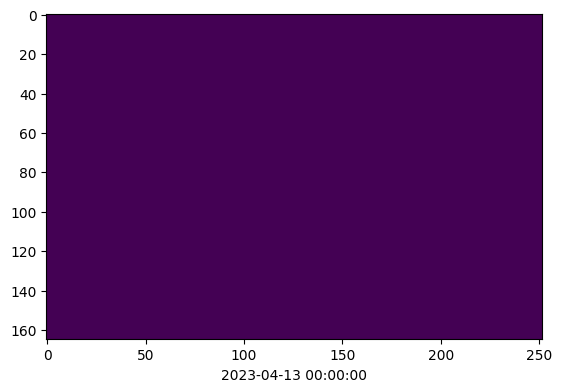

 95%|█████████▌| 77/81 [00:42<00:02,  1.94it/s]

26.53920153920154


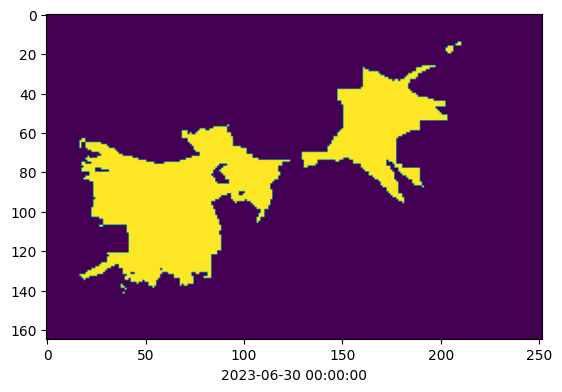

 96%|█████████▋| 78/81 [00:43<00:01,  1.82it/s]

0.0


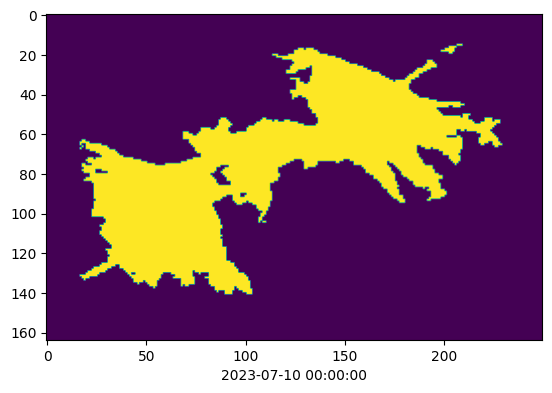

 98%|█████████▊| 79/81 [00:43<00:01,  1.81it/s]

0.0


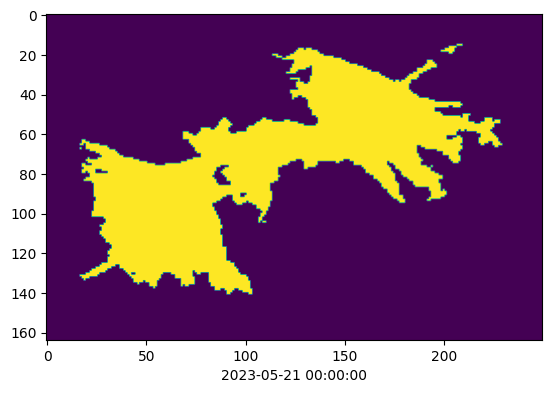

 99%|█████████▉| 80/81 [00:44<00:00,  1.79it/s]

4.9326599326599325


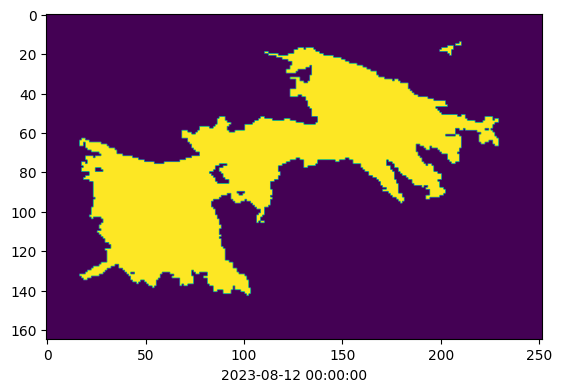

100%|██████████| 81/81 [00:44<00:00,  1.80it/s]


In [65]:
k = 0
date = []
area = []
for f in tqdm(all_files):
    try:
        # Load the raster
        with rio.open(os.path.join(dirpath,f)) as src:
            # Clip the raster using the geometry from the GeoDataFrame
            out_image, out_transform = mask(src, [gdf.geometry.values[0].__geo_interface__], crop=True)
            out_meta = src.meta.copy()
        
        # Update the metadata with the new clipped raster details
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # Save the clipped raster to a new file
        with rio.open('clipped_raster.tif', 'w', **out_meta) as dest:
            dest.write(out_image)
        
        res = rio.open('clipped_raster.tif').read(1)
        cl_cov = res[res==253].shape[0]/res[res>=0].shape[0]*100
        print(cl_cov)
        res[res!=1] = 0
        plt.xlabel(res[res==1].shape[0]*900/10**6)
        plt.imshow(res)
        plt.xlabel(datetime.strptime(f.split('_')[1].split('.')[0],'%Y-%m-%d %H:%M:%S'))
        plt.show()

        date.append(datetime.strptime(f.split('_')[1].split('.')[0],'%Y-%m-%d %H:%M:%S'))
        area.append(res[res==1].shape[0]*900/10**6)
    except ValueError as e:
        # Check if the error is due to non-overlapping shapes
        if "Input shapes do not overlap raster" in str(e):
            print(f"Skipping {f} as it does not overlap with the input shape.")
            continue
        else:
            raise e  
    # if k == 10:
    #     break
    # k = k + 1

In [66]:
hls_df = pd.read_csv(str(res_idx)+'_f.csv')
hls_df['date'] = pd.to_datetime(hls_df['date'], format='%Y%j')
hls_df

Unnamed: 0       date  terrain_area  enh_area1  enh_area2  threshold  \
0           716 2016-01-04        0.0153     8.1981     8.4285       57.0   
1           706 2016-01-20        0.0018     2.7090     8.2494       97.0   
2           603 2016-03-08        1.8702     5.6223     7.5753       96.0   
3            92 2016-04-07        7.7139     7.7139     7.7139        NaN   
4           661 2016-04-09        0.9126     7.1685     7.4979       95.0   
..          ...        ...           ...        ...        ...        ...   
726         653 2022-12-06        3.0816     6.1740     7.4358       96.0   
727         409 2022-12-07        7.4520     7.6905     7.9659       95.0   
728         322 2022-12-10        0.8802     5.4342     7.8363       96.0   
729         218 2022-12-17        7.2675     7.5708     7.9452       95.0   
730         474 2022-12-22        0.0081     7.8030     0.3636       87.0   

     elbow  cloud_cover    datetime  lake_area  
0     22.0     5.770098  2016-01-04     8.1981  
1     49.0    17.184979  2016-01-20        NaN  
2     93.0     2.667594  2016-03-08        NaN  
3      NaN     0.856745  2016-04-07     7.7139  
4     93.0    20.383866  2016-04-09     7.4979  
..     ...          ...         ...        ...  
726   94.0     1.385257  2022-12-06     7.4358  
727   88.0     1.505538  2022-12-07     7.6905  
728   86.0    22.681502  2022-12-10     7.8363  
729   86.0     3.658265  2022-12-17     7.5708  
730   98.0    26.350487  2022-12-22     7.8030  

[731 rows x 10 columns]

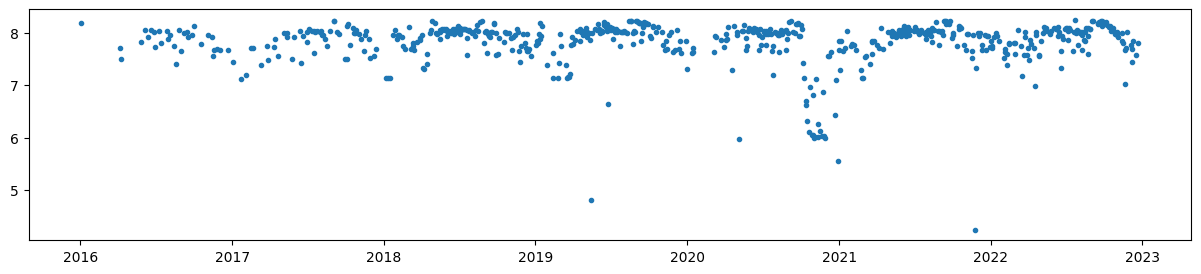

In [67]:
plt.figure(figsize=(15,3))
plt.plot(hls_df['date'],hls_df['lake_area'],'.')

In [68]:
d_ = []
a_ = []
for i in range(len(area)):
    if area[i]>=0:
        a_.append(area[i])
        d_.append(date[i])

In [69]:
new_df = hls_df[hls_df['date']>datetime(2022,1,1)]

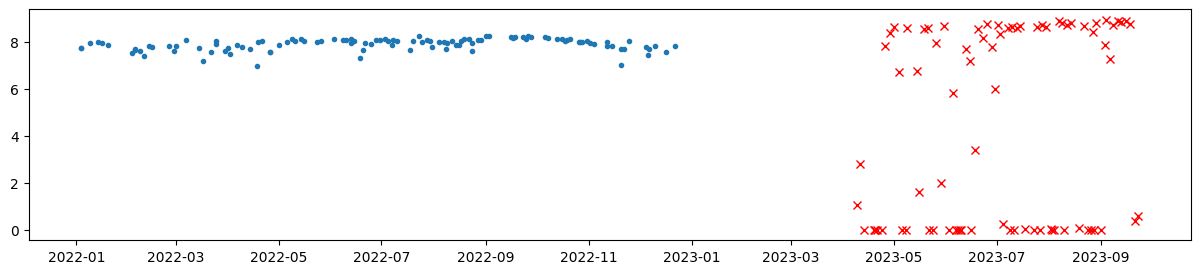

In [70]:
plt.figure(figsize=(15,3))
plt.plot(d_, a_,'rx')
plt.plot(new_df['date'], new_df['lake_area'],'.')